In [ ]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is NOT available.")


CUDA is available!
GPU Name: NVIDIA A40


In [ ]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device())
print("Device name:", torch.cuda.get_device_name(0))


CUDA available: True
Current device: 0
Device name: NVIDIA A40


In [ ]:
import cv2
import io
import base64
import numpy as np
import pandas as pd
from ultralytics import YOLO
from ultralytics.utils.plotting import Annotator
import cv2
import shutil
import os
from typing import List
from PIL import Image
from deepface import DeepFace
# from model.landmark_model import FaceLandmarkModel
import math
import time
import torch
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from scipy.spatial import ConvexHull, KDTree
from itertools import combinations
from joblib import Parallel, delayed
import json
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import PCA #Principal Component Analysis
from sklearn.manifold import TSNE #T-Distributed Stochastic Neighbor Embedding
# import plotly as py
# import plotly.graph_objs as go
import openpyxl
from openpyxl_image_loader import SheetImageLoader
from openpyxl import load_workbook
from openpyxl import Workbook
from openpyxl.drawing.image import Image
import xlsxwriter
import mediapipe as mp
import re

In [ ]:
yolo_models_folder_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/Models/YOLO"
haar_cascades_folder_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/Models/Cascades"
videos_folder_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/AttendanceVideos/LASS_videos"
data_folder_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/data"
temp_folder_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/temp"
clusters_folder_path="/Users/gpuuser2/Desktop/Mahesh_MTP/clusterfiles"
embeddings_dict_file_path = temp_folder_path + '/embeddings'
embeddings_dict_file_name = "embeddings_dict.json"
og_embedding_file ="/home/guest/MTP2/Unsupervised/Notebooks/client2_OG_Embeddings.json"
passport_photos_folder = "/home/guest/MTP2/Unsupervised/Notebooks/temp/PassportPhotosResized"
backends = [
  'opencv',
  'ssd',
  'dlib',
  'mtcnn',
  'fastmtcnn',
  'retinaface',
  'mediapipe',
  'yolov8',
  'yunet',
  'centerface',
]

models = [
  "VGG-Face",
  "Facenet",
  "Facenet512",
  "OpenFace",
  "DeepFace",
  "DeepID",
  "ArcFace",
  "Dlib",
  "SFace",
  "GhostFaceNet",
]


alignment_modes = [True, False]

OPENCV = 0
SSD = 1
DLIB = 2
MTCNN = 3
FASTMTCNN = 4
RETINAFACE = 5 #DOESNT WORK
MEDIAPIPE = 6
YOLOV8 = 7
YUNET = 8
CENTERFACE = 9

VGG = 0
FACENET = 1
FACENET512 = 2
OPENFACE = 3
DEEPFACE = 4
DEEPID = 5
ARCFACE = 6
DLIBM = 7
SFACE = 8
GHOSTFACENET = 9

PCA_plot = 0
TSNE_plot = 1

#### Face extractions

In [ ]:
def extract_frames(videos_folder_path, video_file, data_folder_path):
    path_for_this_video_file = data_folder_path+'/'+video_file[:-4]
    os.makedirs(path_for_this_video_file, exist_ok=True)
    cap = cv2.VideoCapture(os.path.join(videos_folder_path, video_file))
    count = 1
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        cv2.imwrite(os.path.join(path_for_this_video_file, "frame%d.jpg" % count), frame)     # save frame as JPEG file
        count+=1
        cap.release()
        cv2.destroyAllWindows()

def extract_faces_and_frames_yolo(videos_folder_path, video_file, data_folder_path, face_model, conf = 0.5):
    path_for_this_video_file = data_folder_path+'/'+video_file[:-4]
    os.makedirs(path_for_this_video_file, exist_ok=True)
    frame_path = os.path.join(path_for_this_video_file, 'frames')
    face_path = os.path.join(path_for_this_video_file, 'faces')
    os.makedirs(frame_path, exist_ok=True)
    os.makedirs(face_path, exist_ok=True)
    cap = cv2.VideoCapture(os.path.join(videos_folder_path, video_file))
    frame_count = 1
    print("Using confidence ", conf)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue

        face_count=0
        if frame_count%100== 0:
            print("Read frames: ", frame_count)
        results = face_model(frame, conf)
        for result in results:
            for det in result.boxes:
                face_count+=1
                x1,y1,x2,y2 = det.xyxy[0]
                x1 = int(x1)
                y1 = int(y1)
                x2 = int(x2)
                y2 = int(y2)
                cv2.imwrite(os.path.join(face_path, ("frame%d" % frame_count) + ("face%d.jpg" % face_count) ), frame[y1:y2, x1:x2])     # save frame as JPEG file
        cv2.imwrite(os.path.join(frame_path, "frame%d.jpg" % frame_count), frame)     # save frame as JPEG file
        frame_count+=1
    cap.release()
    cv2.destroyAllWindows()

def extract_faces_and_frames_haar(videos_folder_path, video_file, data_folder_path, haar_cascade_path, conf = 0.5):
    path_for_this_video_file = data_folder_path+'/'+video_file[:-4]
    os.makedirs(path_for_this_video_file, exist_ok=True)
    frame_path = os.path.join(path_for_this_video_file, 'frames')
    face_path = os.path.join(path_for_this_video_file, 'faces')
    os.makedirs(frame_path, exist_ok=True)
    os.makedirs(face_path, exist_ok=True)
    cap = cv2.VideoCapture(os.path.join(videos_folder_path, video_file))
    frame_count = 1
    face_model = cv2.CascadeClassifier(haar_cascade_path)
    print("Using confidence ", conf)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            continue

        face_count=0
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        if frame_count%100== 0:
            print("Read frames: ", frame_count)
        results = face_model.detectMultiScale(
            gray,
            scaleFactor=1.2,
            minNeighbors=5,
            minSize=(20,20)
        )
        for x,y,w,h in results:
            face_count+=1
            cv2.imwrite(os.path.join(face_path, ("frame%d" % frame_count) + ("face%d.jpg" % face_count) ), frame[y:y+h, x:x+w])     # save frame as JPEG file
        cv2.imwrite(os.path.join(frame_path, "frame%d.jpg" % frame_count), frame)     # save frame as JPEG file
        frame_count+=1
    cap.release()
    cv2.destroyAllWindows()

def extract_faces_and_frames_deepface(videos_folder_path, video_file, data_folder_path, face_model_type, conf = 0.5):
    path_for_this_video_file = data_folder_path+'/'+video_file[:-4]
    os.makedirs(path_for_this_video_file, exist_ok=True)
    frame_path = os.path.join(path_for_this_video_file, 'frames')
    face_path = os.path.join(path_for_this_video_file, 'faces')
    os.makedirs(frame_path, exist_ok=True)
    os.makedirs(face_path, exist_ok=True)
    cap = cv2.VideoCapture(os.path.join(videos_folder_path, video_file))
    frame_count = 1
    print("Using confidence ", conf)

    start_time = time.time()
    print("--- %s seconds elapsed ---" % (time.time() - start_time))

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        face_count=0
        cv2.imwrite(os.path.join(frame_path, "frame%d.jpg" % frame_count), frame)     # save frame as JPEG file

        face_objs = DeepFace.extract_faces(
            img_path=os.path.join(frame_path, "frame%d.jpg" % frame_count),
            detector_backend = backends[face_model_type],
            align = True,
            enforce_detection = False
        )
        if frame_count%100 == 0:
            print("Read frames: ", frame_count)
            print("--- %s seconds elapsed ---" % (time.time() - start_time))
        for face_obj in face_objs:
            confidence = face_obj['confidence']
            if confidence < conf:
                continue
            face_count+=1
            he,wi,ch = frame.shape
            x = int(math.floor(face_obj['facial_area']['x']))
            y = int(math.floor(face_obj['facial_area']['y']))
            w = int(math.floor(face_obj['facial_area']['w']))
            h = int(math.floor(face_obj['facial_area']['h']))
            cv2.imwrite(os.path.join(face_path, ("frame%d" % frame_count) + ("face%d.jpg" % face_count) ), frame[max(0,y-30):min(20+y+h,he), max(0,x-20):min(20+x+w, wi)])     # save frame as JPEG file
        frame_count+=1
    cap.release()
    cv2.destroyAllWindows()

def create_dataset(video_files, data_folder_path, videos_folder_path, face_model, modeltype='HAAR', conf=0.5, n=10):
    count=0
    list_of_already_extracted = [folder for folder in os.listdir(data_folder_path)]
    print('already extracted: ', list_of_already_extracted)
    start_time = time.time()
    current_time = start_time
    previous_time = start_time
    dict_times = {}
    for video_file in video_files:
    # for video_file in ['VIDEO-2024-08-05-18-01-32.mp4']:
        if video_file[:-4] in list_of_already_extracted:
            continue
        print('going to start: ', video_file)
        previous_time = current_time
        current_time = time.time()
        dict_times[video_file] = current_time-previous_time
        count+=1
        if modeltype=='YOLO':
            extract_faces_and_frames_yolo(videos_folder_path, video_file, data_folder_path, face_model, conf)
        elif modeltype=='HAAR':
            haar_cascade_path=face_model
            extract_faces_and_frames_haar(videos_folder_path, video_file, data_folder_path, haar_cascade_path, conf)
        elif modeltype=='DEEPFACE':
            haar_cascade_path=face_model
            extract_faces_and_frames_deepface(videos_folder_path, video_file, data_folder_path, haar_cascade_path, conf)
        if count == n:
            break
    print('dict ', dict_times)
    print('final ', str(time.time()-current_time))



#### Quality filtration

In [ ]:
def vgg_preprocess(im):
    im = cv2.resize(im, (500, 500))
    in_ = np.array(im, dtype=np.float32)
    in_ = in_[:,:,::-1]
    in_ -= np.array((104.00698793,116.66876762,122.67891434))
    in_ = in_[np.newaxis,:]
    #in_ = in_.transpose((2,0,1))
    return in_

def auto_downscaling(im):
    w = im.shape[1]
    h = im.shape[0]
    while w*h >= 700*700:
        im = cv2.resize(im, (0,0), fx=0.5, fy=0.5)
        w = im.shape[1]
        h = im.shape[0]
    return im

def getCroppedFace(image):
    # Initialize MediaPipe Face Detection
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection()

    face = face_detection.process(image)
    if face.detections:
        for detection in face.detections:
            bboxC = detection.location_data.relative_bounding_box
            ih, iw, _ = image.shape
            x, y, w, h = int(bboxC.xmin * iw), int(bboxC.ymin * ih), int(bboxC.width * iw), int(bboxC.height * ih)
        # Crop the face from the image
        cropped_face = image[y:y + h, x:x + w]
        return cropped_face
    else:
        return None

def face_confidence_score(image):
    mp_face_detection = mp.solutions.face_detection
    face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.2)
    mp_drawing = mp.solutions.drawing_utils
    face_detection_results = face_detection.process(image)

    if face_detection_results.detections:
        for face_no, face in enumerate(face_detection_results.detections):
            img_copy = image.copy()
            mp_drawing.draw_detection(image=img_copy, detection=face, keypoint_drawing_spec=mp_drawing.DrawingSpec(color=(255, 0, 0), thickness=15, circle_radius=10))
            # fig = plt.figure(figsize = [5, 5])
            # plt.title("Resultant Image");plt.axis('off');plt.imshow(img_copy);plt.show()
            return round(face.score[0], 2), img_copy
    else:
        return None, None




In [ ]:
def get_variance_of_laplacian(image_path):
    image = cv2.imread(image_path)
    return cv2.Laplacian(image, cv2.CV_64F).var()

def is_blurred(image_path, threshold):
    if get_variance_of_laplacian(image_path) < threshold:
        return True
    return False

def is_small(image_path, size):
    image = cv2.imread(image_path)
    n,m,c = image.shape
    if n>size and m>size:
        return False
    return True

def is_obstructed(image_path, threshold):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    global precomputed_obstruction
    if image_path not in precomputed_obstruction:
        face_confidence, face_landmarks = face_confidence_score(image)
        precomputed_obstruction[image_path] = face_confidence
    face_confidence = precomputed_obstruction[image_path]
    if (face_confidence is None) or (face_confidence <= threshold):
        return True
    return False

def precompute_obstruction(image_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    global precomputed_obstruction
    if image_path not in precomputed_obstruction:
        face_confidence, face_landmarks = face_confidence_score(image)
        precomputed_obstruction[image_path] = face_confidence

def check_whether_frame_is_suitable(path_to_extracted, file, occlusion_perc):
    image_path = os.path.join(path_to_extracted, file)
    img = cv2.imread(os.path.join(path_to_extracted, file))
    n, m, c = img.shape
    if  (is_small(image_path, 20)) or (is_obstructed(image_path, occlusion_perc)) or (is_blurred(image_path, 50)):
        return False

    return True
# 35 55
# 95 75 0.9
def get_scores(path_to_extracted, file, face_detection_model):
    face_path = os.path.join(path_to_extracted, file)
    face_objs = DeepFace.extract_faces(
        img_path=face_path,
        detector_backend=backends[face_detection_model],
        align=True,
        enforce_detection=False
    )
    for face_obj in face_objs:
        confidence = face_obj['confidence']
        img = cv2.imread(face_path)
        n,m,c = img.shape
        size_tuple = (n,m)
        variance_of_laplacian = cv2.Laplacian(img, cv2.CV_64F).var()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        occlusion_confidence_score, landmarks = face_confidence_score(img)
        return confidence, size_tuple, variance_of_laplacian, occlusion_confidence_score



In [ ]:
def NoiseRemoval(X: List[List[float]], min_neighbours: int, removal_percentage: float, min_dist:float = 0.1, max_dist: float = 1, step: float = 0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    X_tensor = torch.tensor(X, device=device)
    # print(device)
    n = len(X)
    max_allowed_noise = int((removal_percentage/100)*n)
    threshold_dist = min_dist
    while threshold_dist<=max_dist:
        # print("here")
        dists = torch.cdist(X_tensor, X_tensor)
        # print("here1")
        neighbors_count = torch.sum(dists<threshold_dist, dim=1)-1
        noise_points = torch.sum(neighbors_count<min_neighbours).item()
        # print("here2")
        if noise_points <= max_allowed_noise:
            labels = (neighbors_count>=min_neighbours).int().tolist()
            return threshold_dist, labels
        # print("here3")
        threshold_dist += step
    return None, [0]*n



#### Embedding generation

In [ ]:
def get_dict_list_of_facepath(data_folder_path, video_files, n=1000000):
    count=0
    result = {}
    for video_file in video_files:
        count+=1
        print(video_file + ' extracting: Get Dict List Of Facepath')
        templist = []
        path_to_extracted = os.path.join(data_folder_path, video_file[:-4], "faces")
        templist = [file for file in os.listdir(path_to_extracted) if file.endswith((".jpg"))]
        result[video_file] = [file for file in templist]# if check_whether_frame_is_suitable(path_to_extracted, file)]
        if count == n:
            break
    return result

def get_embedding_for_single_face(image_path, face_detection_model_type, face_embedding_model_type):
    # print(image_path)
    embedding_objs = DeepFace.represent(
    img_path = image_path,
    detector_backend = backends[face_detection_model_type],
    align = True,
    model_name = models[face_embedding_model_type],
    enforce_detection = False
    )
    if len(embedding_objs)==0:
        return None
    return embedding_objs[0]['embedding']

def get_file_to_embedding_for_videos(data_folder_path, video_files, face_detection_model_type, face_embedding_model_type, n=500000):
    videowise_list_of_facepaths = get_dict_list_of_facepath(data_folder_path, video_files)
    extracted_videos = list(videowise_list_of_facepaths.keys())
    print('Extracted list of facepaths')
    result = {}
    for video in extracted_videos:
        frame_paths = videowise_list_of_facepaths[video]
        count=0
        for frame_path in frame_paths:
            count+=1
            if (count%1000) == 0:
                print(str(count) + 'completed: Single Face Embedding')
            path_to_frame = os.path.join(data_folder_path, video[:-4], "faces", frame_path)
            result[frame_path] = get_embedding_for_single_face(path_to_frame, face_detection_model_type, face_embedding_model_type)
            if count == n:
                break
    return result

def save_dict_frame_to_embedding(dictionary_frame_to_embedding, temp_folder_path, embeddings_dict_file_name, embeddings_dict_file_path, video_file):
    os.makedirs(temp_folder_path, exist_ok=True)
    os.makedirs(embeddings_dict_file_path, exist_ok=True)
    os.makedirs(os.path.join(embeddings_dict_file_path, video_file[:-4]), exist_ok=True)
    embedding_temp_file_path = os.path.join(embeddings_dict_file_path, video_file[:-4], embeddings_dict_file_name)
    with open(embedding_temp_file_path, "a+") as outfile:
        json.dump(dictionary_frame_to_embedding, outfile)



#### Clustering

In [ ]:
def min_except_diagonal(df):

    if df.empty or df.shape[0] <= 1 or df.shape[1] <= 1:
        return None

    temp_df = df.copy()
    np.fill_diagonal(temp_df.values, np.max(temp_df.values))
    return temp_df.min().min()

In [ ]:
def compute_convex_hull(cluster):
    cluster = np.array(cluster)
    if len(cluster) < cluster.shape[1] + 1:
        return cluster
    return ConvexHull(cluster)

def convex_hull_distance(hull1, hull2):
    points1 = hull1.points[hull1.vertices] if isinstance(hull1, ConvexHull) else hull1
    points2 = hull2.points[hull2.vertices] if isinstance(hull2, ConvexHull) else hull2

    tree1, tree2 = KDTree(points1), KDTree(points2)
    min_dist_1 = np.min(tree1.query(points2)[0])
    min_dist_2 = np.min(tree2.query(points1)[0])
    return min(min_dist_1, min_dist_2)

def compute_overlap(i, j, hull1, hull2):
    min_dist = convex_hull_distance(hull1, hull2)

    if isinstance(hull1, ConvexHull) and isinstance(hull2, ConvexHull):
        all_inside1 = all(np.all(hull1.equations @ np.append(p, 1) <= 1e-9) for p in hull2.points)
        all_inside2 = all(np.all(hull2.equations @ np.append(p, 1) <= 1e-9) for p in hull1.points)

        if all_inside1 or all_inside2:
            return i, j, ["Fully Overlapping (One Inside Another)", 0.0, 0.0]
        elif min_dist == 0:
            return i, j, ["Partially Overlapping (Convex Hulls Intersect)", min_dist, 0.2]

    return i, j, [f"Fully Separated (Min Distance: {min_dist:.4f})", min_dist, min(1.0, min_dist / 10)]

def check_cluster_overlap(X, labels, n_jobs=None):
    X = np.array(X)
    labels = np.array(labels)

    unique_labels = sorted(set(labels) - {-1})
    clusters = {label: X[labels == label] for label in unique_labels}

    hulls = Parallel(n_jobs=n_jobs)(delayed(compute_convex_hull)(clusters[l]) for l in unique_labels)

    results = Parallel(n_jobs=n_jobs)(
        delayed(compute_overlap)(i, j, hulls[idx1], hulls[idx2])
        for idx1, i in enumerate(unique_labels)
        for idx2, j in enumerate(unique_labels) if i < j
    )

    df_matrix = pd.DataFrame(index=unique_labels, columns=unique_labels, dtype=object)
    for label in unique_labels:
        df_matrix.at[label, label] = ["Self", 0.0, 1.0]

    for i, j, data in results:
        df_matrix.at[i, j] = data
        df_matrix.at[j, i] = data

    return df_matrix



In [ ]:
def get_embedding_2D_array(dictionary_frame_to_embedding):
    X = []
    new_frame_list = []
    count = 0
    frame_list = list(dictionary_frame_to_embedding.keys())
    for frame in frame_list:
        if dictionary_frame_to_embedding[frame] is not None and not np.isnan(dictionary_frame_to_embedding[frame][0]).any():
            X.append(list(dictionary_frame_to_embedding[frame]))
            new_frame_list.append(frame)
    return X, new_frame_list

def get_dict_label_to_file(list_of_labels, frame_list):
    dict_label_to_file = {}
    for i in np.unique(list_of_labels):
        dict_label_to_file[i] = [frame_list[index] for index in range(len(list_of_labels)) if list_of_labels[index] == i]
    return dict_label_to_file

def save_clusters(list_of_labels, dict_label_to_file, video_file, eps, min_samples, metric, temp_folder_path, type_of_clustering):
    path_of_base_folder = video_file[:-4] + '_' + type_of_clustering + "_" + metric + "_" + str(eps) + "_" + str(min_samples)
    path_to_save_base = os.path.join(temp_folder_path, path_of_base_folder)
    os.makedirs(os.path.join(path_to_save_base), exist_ok=True)
    for label in np.unique(list_of_labels):
        path_to_save = os.path.join(path_to_save_base, str(label))
        os.makedirs(path_to_save, exist_ok=True)
        original_path = os.path.join(data_folder_path, video_file[:-4], "faces")
        for file in dict_label_to_file[label]:
            img = cv2.imread(os.path.join(original_path,file))
            img1 = cv2.resize(img, (100,100))
            cv2.imwrite(os.path.join(path_to_save, file), img1)
            # shutil.copy(os.path.join(original_path,file), os.path.join(path_to_save, file))

def save_stage1_rejects(list_of_frames, labels, video_file, temp_folder_path):
    path_of_base_folder = video_file[:-4]
    path_to_save_base = os.path.join(temp_folder_path, 'Stage1', path_of_base_folder)
    os.makedirs(path_to_save_base, exist_ok=True)
    count=0
    for label in labels:
        if label==0:
            original_path = os.path.join(data_folder_path, video_file[:-4], "faces")
            file = list_of_frames[count]
            img = cv2.imread(os.path.join(original_path,file))
            img1 = cv2.resize(img, (100,100))
            cv2.imwrite(os.path.join(path_to_save_base, file), img1)
        count+=1



### Actual code

#### Declarations

In [ ]:
video_files = '06_08_2025.MOV'#'VID_20250307_102529311.mp4' #in attendance folder directory [folder for folder in os.listdir(videos_folder_path)]
output_excel_file = "results_IMG_1447.xlsx"
attendance_excel_file = 'attendance_IMG_1447.xlsx'
output_video_file = video_files
face_detection_model = YOLOV8
face_embedding_model = VGG
video_file = video_files
output_video_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/output_videos"
output_video_file = output_video_path + '/' + output_video_file



In [ ]:
# metric = "correlation"
# eps = 0.22
# min_samples = 6
# metric = "correlation"
# eps = 0.35506
# min_samples = 3
# metric = "correlation"
# eps = 0.3325
# min_samples = 3
metric = "correlation"
eps = 0.28 #345
min_samples = 11
occ_perc = 0.7#0.9075#0.925 88

In [ ]:
saved_folder_name = video_file[:-4] + '_DBSCAN_' + metric + '_' + str(eps) + '_' + str(min_samples)
attendance_folder_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/attendancefiles"
attendance_excel_file = attendance_folder_path + '/' + attendance_excel_file
output_excel_path = "/Users/gpuuser2/Desktop/Mahesh_MTP/clusterfiles"
output_excel_file = output_excel_path + '/' + output_excel_file
precomputed_obstruction = {}

##### Dataset and embeddings creation

In [ ]:
# dataset create -- face and frame folders from video_file
create_dataset([video_files], data_folder_path, videos_folder_path, face_detection_model, modeltype='DEEPFACE', conf=0.8)
#create_dataset([video_files], data_folder_path, videos_folder_path, YOLOV8, modeltype='DEEPFACE', conf=0.5)
# 46 seconds long vid -- 1m 54.3 s (112.3s) = 2.5 s/s

already extracted:  ['03_09_2025', '07_11_2025', '08_08_2025', '08_10_2025', '09_10_2025', '10_09_2025', '11_09_2025', '12_09_2025', '13_08_2025', '14_08_2025', '15_10_2025', '16_10_2025', '17_10_2025', '20_08_2025', '21_08_2025', '22_08_2025', '22_10_2025', '23_07_2025', '23_10_2025', '24_07_2025', '24_10_2025', '27_08_2025', '28_08_2025', '29_08_2025', '29_10_2025', '30_07_2025', '30_10_2025', '31_07_2025', '31_10_2025', 'ptz_capture_classroom', 'ptz_capture_classroom_DBSCAN_correlation_0.28_11', 'VID_20250307_102529311', 'VID_wed_1', 'VID_wed_1_DBSCAN_correlation_0.28_11']
going to start:  06_08_2025.MOV
Using confidence  0.8
--- 0.0 seconds elapsed ---


WARNING  NMS time limit 0.550s exceeded


Read frames:  100
--- 25.798186779022217 seconds elapsed ---
Read frames:  200
--- 43.447885274887085 seconds elapsed ---
Read frames:  300
--- 61.06406569480896 seconds elapsed ---
Read frames:  400
--- 78.74736404418945 seconds elapsed ---
Read frames:  500
--- 95.60995411872864 seconds elapsed ---
Read frames:  600
--- 113.34544038772583 seconds elapsed ---
Read frames:  700
--- 131.24180340766907 seconds elapsed ---
Read frames:  800
--- 149.92681884765625 seconds elapsed ---
Read frames:  900
--- 168.29907488822937 seconds elapsed ---
Read frames:  1000
--- 186.54033493995667 seconds elapsed ---
dict  {'06_08_2025.MOV': 0.0}
final  188.7174632549286


In [ ]:
# only first time
for video_file in [video_files]:
    dictionary_frame_to_embedding = get_file_to_embedding_for_videos(data_folder_path, [video_file], face_detection_model, face_embedding_model)
    save_dict_frame_to_embedding(dictionary_frame_to_embedding, temp_folder_path, embeddings_dict_file_name, embeddings_dict_file_path, video_file)
# 46 sec, 4100 face imgs -- 3m 57.2s -- 237s

06_08_2025.MOV extracting: Get Dict List Of Facepath
Extracted list of facepaths
1000completed: Single Face Embedding
2000completed: Single Face Embedding


In [ ]:
with open(os.path.join(embeddings_dict_file_path, video_files[:-4], embeddings_dict_file_name)) as readfile:
    dictionary_frame_to_embedding = json.load(readfile)

In [ ]:
print(len(dictionary_frame_to_embedding))

2050


2050


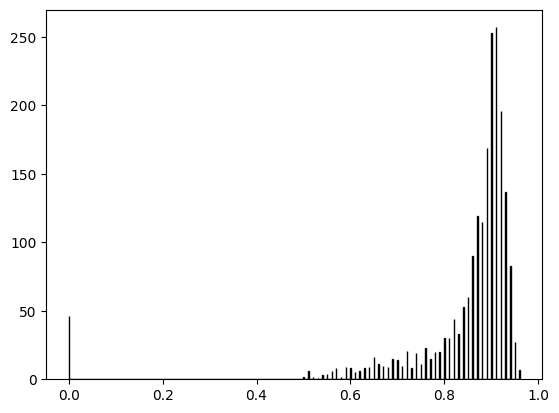

0.71


In [ ]:
import os

path_to_extracted = os.path.join(data_folder_path, video_file[:-4], "faces")
for key in dictionary_frame_to_embedding:
    precompute_obstruction(os.path.join(path_to_extracted,key))
print(len(precomputed_obstruction))
occ_perc_list = []
for key in precomputed_obstruction:
    occ_perc_list.append(precomputed_obstruction[key])
occ_perc_list_all = [0 if item is None else item for item in occ_perc_list]
plt.hist(occ_perc_list_all, bins=1000, color = 'skyblue', edgecolor = 'black')
plt.show()
threshold_occ_perc = np.percentile(occ_perc_list_all, 10)
print(threshold_occ_perc)

In [ ]:
print(len(dictionary_frame_to_embedding))
new_dict_frame_to_embeddingg = {}
video_file = video_files
path_to_extracted = os.path.join(data_folder_path, video_file[:-4], "faces")
for key in dictionary_frame_to_embedding:
    if check_whether_frame_is_suitable(path_to_extracted, key, occ_perc):#925
        new_dict_frame_to_embeddingg[key] = dictionary_frame_to_embedding[key]

dictionary_frame_to_embedding = new_dict_frame_to_embeddingg
print(len(dictionary_frame_to_embedding))

# before occ 4103, 1830 -- 15.3s -- 27 -- 0.34
# after occ 1827 -- 1m 9.3s (conf threshold = 0.7) -- 27 -- 0.34
# after occ 1779 -- 49.9s (0.8) -- 26 -- 0.35
# after occ 935 -- 54.6s (0.9) -- 17 -- 0.41
# after occ 443 -- 1m 54.3s (0.92) -- n_labels = 11 -- silhoutte score = 0.44

2050
1164


##### Quick grid search

In [ ]:
metricss_all_ = ['correlation']
dict_metrics_start_stop = {}
face_folder_path = '/home/guest/Mahesh_MTP/data/VID_wed_1/faces'
face1_list = ["frame29face1.jpg", "frame31face1.jpg", "frame32face1.jpg"]
face2_list = ["frame38face1.jpg", "frame14face2.jpg", "frame15face1.jpg"]
face1_paths = [os.path.join(face_folder_path, file) for file in face1_list]
face2_paths = [os.path.join(face_folder_path, file) for file in face2_list]
face1_embeddings = {}
face2_embeddings = {}
for path in face1_paths:
    embedding = get_embedding_for_single_face(path, MTCNN, VGG)
    face1_embeddings[path] = embedding
for path in face2_paths:
    embedding = get_embedding_for_single_face(path, MTCNN, VGG)
    face2_embeddings[path] = embedding
face1_df = pd.DataFrame(columns=face1_list, index=face1_list)
face2_df = pd.DataFrame(columns=face2_list, index=face2_list)
face12_df = pd.DataFrame(columns=face2_list, index=face1_list)
for metricc in metricss_all_:
    mini = 10000
    maxi = 10000
    for path in face1_paths:
        embedding = np.array(face1_embeddings[path])
        for path1 in face1_paths:
            embedding1 = np.array(face1_embeddings[path1])
            facea = path[path.rfind('\\')+1:]
            faceb = path1[path1.rfind('\\')+1:]
            metric = metricc
            distance = metrics.pairwise_distances(embedding.reshape((1,-1)), embedding1.reshape((1,-1)), metric)
            # print("distance type ", metric, " distance ", distance)
            face1_df[facea][faceb] = distance[0][0]
            if distance[0][0] != 0:
                mini = min(mini, distance[0][0])

    for path in face2_paths:
        embedding = np.array(face2_embeddings[path])
        for path1 in face2_paths:
            embedding1 = np.array(face2_embeddings[path1])
            facea = path[path.rfind('\\')+1:]
            faceb = path1[path1.rfind('\\')+1:]
            metric = metricc
            distance = metrics.pairwise_distances(embedding.reshape((1,-1)), embedding1.reshape((1,-1)), metric)
            # print("distance type ", metric, " distance ", distance)
            face2_df[facea][faceb] = distance[0][0]

    for path in face1_paths:
        embedding = np.array(face1_embeddings[path])
        for path1 in face2_paths:
            embedding1 = np.array(face2_embeddings[path1])
            facea = path[path.rfind('\\')+1:]
            faceb = path1[path1.rfind('\\')+1:]
            metric = metricc
            distance = metrics.pairwise_distances(embedding.reshape((1,-1)), embedding1.reshape((1,-1)), metric)
            # print("distance type ", metric, " distance ", distance)
            face12_df[faceb][facea] = distance[0][0]
            if distance[0][0]!=0:
                maxi = min(maxi, distance[0][0])
    dict_metrics_start_stop[metricc] = (mini, maxi)


KeyboardInterrupt: 

In [ ]:
import os
from sklearn import metrics
import pandas as pd
import numpy as np

metricss_all_ = ['correlation']
dict_metrics_start_stop = {}
face_folder_path = '/home/guest/Mahesh_MTP/data/VID_wed_1/faces'
face1_list = ["frame29face1.jpg", "frame31face1.jpg", "frame32face1.jpg"]
face2_list = ["frame38face1.jpg", "frame14face2.jpg", "frame15face1.jpg"]
face1_paths = [os.path.join(face_folder_path, file) for file in face1_list]
face2_paths = [os.path.join(face_folder_path, file) for file in face2_list]

# Get embeddings (assuming this function exists)
face1_embeddings = {}
face2_embeddings = {}
for path in face1_paths:
    embedding = get_embedding_for_single_face(path, MTCNN, VGG)
    face1_embeddings[path] = embedding
for path in face2_paths:
    embedding = get_embedding_for_single_face(path, MTCNN, VGG)
    face2_embeddings[path] = embedding

# Create DataFrames
face1_df = pd.DataFrame(columns=face1_list, index=face1_list)
face2_df = pd.DataFrame(columns=face2_list, index=face2_list)
face12_df = pd.DataFrame(columns=face2_list, index=face1_list)

for metricc in metricss_all_:
    mini = 10000
    maxi = 10000

    # Process face1 comparisons
    for path in face1_paths:
        embedding = np.array(face1_embeddings[path])
        for path1 in face1_paths:
            embedding1 = np.array(face1_embeddings[path1])
            # FIXED: Use os.path.basename instead of rfind
            facea = os.path.basename(path)
            faceb = os.path.basename(path1)
            metric = metricc
            distance = metrics.pairwise_distances(embedding.reshape((1,-1)), embedding1.reshape((1,-1)), metric)
            face1_df[facea][faceb] = distance[0][0]
            if distance[0][0] != 0:
                mini = min(mini, distance[0][0])

    # Process face2 comparisons
    for path in face2_paths:
        embedding = np.array(face2_embeddings[path])
        for path1 in face2_paths:
            embedding1 = np.array(face2_embeddings[path1])
            # FIXED: Use os.path.basename instead of rfind
            facea = os.path.basename(path)
            faceb = os.path.basename(path1)
            metric = metricc
            distance = metrics.pairwise_distances(embedding.reshape((1,-1)), embedding1.reshape((1,-1)), metric)
            face2_df[facea][faceb] = distance[0][0]

    # Process cross-face comparisons
    for path in face1_paths:
        embedding = np.array(face1_embeddings[path])
        for path1 in face2_paths:
            embedding1 = np.array(face2_embeddings[path1])
            # FIXED: Use os.path.basename instead of rfind
            facea = os.path.basename(path)
            faceb = os.path.basename(path1)
            metric = metricc
            distance = metrics.pairwise_distances(embedding.reshape((1,-1)), embedding1.reshape((1,-1)), metric)
            face12_df[faceb][facea] = distance[0][0]
            if distance[0][0] != 0:
                maxi = min(maxi, distance[0][0])

    dict_metrics_start_stop[metricc] = (mini, maxi)


##### Clustering

In [ ]:
X, new_frame_list = get_embedding_2D_array(dictionary_frame_to_embedding)
print(len(X))

1164


In [ ]:
thres, lab = NoiseRemoval(X,3,5,0.01,5,0.001)
print(thres, lab)

0.6810000000000005 [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [ ]:
save_stage1_rejects(new_frame_list, lab, video_file, temp_folder_path)

In [ ]:
print(new_frame_list)

['frame100face1.jpg', 'frame100face2.jpg', 'frame100face3.jpg', 'frame100face4.jpg', 'frame100face5.jpg', 'frame100face6.jpg', 'frame101face1.jpg', 'frame101face2.jpg', 'frame101face3.jpg', 'frame101face4.jpg', 'frame101face5.jpg', 'frame101face6.jpg', 'frame102face2.jpg', 'frame102face3.jpg', 'frame102face4.jpg', 'frame102face5.jpg', 'frame103face2.jpg', 'frame103face3.jpg', 'frame103face4.jpg', 'frame103face5.jpg', 'frame103face6.jpg', 'frame103face7.jpg', 'frame104face2.jpg', 'frame104face4.jpg', 'frame104face5.jpg', 'frame104face6.jpg', 'frame105face1.jpg', 'frame105face3.jpg', 'frame105face4.jpg', 'frame105face5.jpg', 'frame105face6.jpg', 'frame105face7.jpg', 'frame106face2.jpg', 'frame106face3.jpg', 'frame106face5.jpg', 'frame106face6.jpg', 'frame107face1.jpg', 'frame107face3.jpg', 'frame107face4.jpg', 'frame107face5.jpg', 'frame107face6.jpg', 'frame108face2.jpg', 'frame108face3.jpg', 'frame108face5.jpg', 'frame109face2.jpg', 'frame109face3.jpg', 'frame109face4.jpg', 'frame109fac

In [ ]:
X_filtered, frame_list_filtered = list(zip(*[(X[i], new_frame_list[i]) for i in range(len(X)) if lab[i]!=0]))
print(len(X_filtered))
print(len(frame_list_filtered))

1106
1106


In [ ]:
X = X_filtered
new_frame_list = frame_list_filtered

In [ ]:
db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric).fit(X)
labels = db.labels_
num_clusters = len(np.unique(labels))
print(np.unique(labels))
sc = metrics.silhouette_score(X, labels)
print("Silhouette Score:%0.2f" % sc)
print(len(np.unique(labels))-1)

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Silhouette Score:0.48
20


In [ ]:
df_min_intercluster = check_cluster_overlap(X, labels)
min_dist_df = df_min_intercluster.applymap(lambda x: x[1] if isinstance(x, list) else None)
csv_filename = "cluster_min_distances.csv"
if os.path.exists(csv_filename):
    min_dist_df.to_csv(csv_filename, mode='w', index=True)  # Overwrite mode
else:
    min_dist_df.to_csv(csv_filename, index=True)

print("Silhouette Score:%0.2f" % sc)
print("Min separation:%0.2f" % min_except_diagonal(min_dist_df))


Silhouette Score:0.48
Min separation:0.82


In [ ]:
dict_label_to_file = get_dict_label_to_file(labels, new_frame_list)
save_clusters(labels, dict_label_to_file, video_file, eps, min_samples, metric, clusters_folder_path, "DBSCAN")

In [ ]:
saved_folder_name = video_file[:-4] + '_DBSCAN_' + metric + '_' + str(eps) + '_' + str(min_samples)
print(saved_folder_name)

06_08_2025_DBSCAN_correlation_0.28_11


## Create OG Embeddings

In [ ]:
import os, json, cv2, glob
from deepface import DeepFace

# === Paths ===
client_roll_to_photos_path = "/home/guest/Mahesh_MTP/single_photos"
passport_photos_folder = "/home/guest/Mahesh_MTP/temp/passport_thumbs_final"
os.makedirs(passport_photos_folder, exist_ok=True)

og_embedding_file = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings_final.json"
os.makedirs(os.path.dirname(og_embedding_file), exist_ok=True)

# === Settings ===
detector_backend = "yolov8"
embedding_model = "VGG-Face"
valid_exts = (".jpg", ".jpeg", ".png")

# -------------------------
# Helpers
# -------------------------
def find_image_files(base_path):
    pattern = os.path.join(base_path, "**", "*.*")
    all_files = glob.glob(pattern, recursive=True)
    img_files = [f for f in all_files if f.lower().endswith(valid_exts)]
    return sorted(img_files)

def get_embedding(img_path):
    try:
        reps = DeepFace.represent(
            img_path=img_path,
            model_name=embedding_model,
            detector_backend=detector_backend,
            enforce_detection=True
        )
        if reps and isinstance(reps, list):
            return reps[0]["embedding"], None
        return None, "No face detected"
    except Exception as e:
        return None, str(e)

# -------------------------
# Main loop
# -------------------------
image_files = find_image_files(client_roll_to_photos_path)
print(f"Found {len(image_files)} image files (scanning {client_roll_to_photos_path})\n")

emb_dict = {}
failures = []

for img_path in image_files:
    fname = os.path.basename(img_path)
    emb, err = get_embedding(img_path)
    if emb is not None:
        emb_dict[fname] = emb
    else:
        failures.append((fname, err))

    # save thumbnail (50x50)
    img = cv2.imread(img_path)
    if img is not None:
        thumb = cv2.resize(img, (50, 50))
        cv2.imwrite(os.path.join(passport_photos_folder, fname), thumb)

# Save JSON
with open(og_embedding_file, "w") as fp:
    json.dump(emb_dict, fp)

print("\n==== SUMMARY ====")
print(f"Total images scanned: {len(image_files)}")
print(f"Embeddings stored:    {len(emb_dict)}")
print(f"Failures:             {len(failures)}")
print(f"Saved JSON:           {og_embedding_file}")
print(f"Thumbnails saved in:  {passport_photos_folder}")

if failures:
    print("\nSome failures:")
    for fname, err in failures[:10]:
        print(f" - {fname}: {err}")


2025-11-07 05:56:01.719031: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-07 05:56:01.772266: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-07 05:56:02.457667: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Found 59 image files (scanning /home/guest/Mahesh_MTP/single_photos)



2025-11-07 05:56:04.042738: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...



==== SUMMARY ====
Total images scanned: 59
Embeddings stored:    59
Failures:             0
Saved JSON:           /home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings_final.json
Thumbnails saved in:  /home/guest/Mahesh_MTP/temp/passport_thumbs_final


In [ ]:
import json

# === Load the saved embeddings JSON ===
og_embedding_file = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings_final.json"

with open(og_embedding_file, "r") as fp:
    dict_og_embeddings = json.load(fp)

# === Extract student roll numbers from filenames ===
list_of_student_rollno = []
for key in dict_og_embeddings.keys():
    # Assuming filenames start with roll number (e.g., "123456789012.jpg")
    list_of_student_rollno.append(key[:9])   # adjust slice if rollno length differs

# Remove duplicates and sort
list_of_student_rollno = sorted(set(list_of_student_rollno))

print(f"Total unique students: {len(list_of_student_rollno)}")
print(list_of_student_rollno[:10])  # show first 10 as sample


Total unique students: 59
['21EE32001', '22EE37013', '22EE38001', '22EE38002', '22EE38003', '22EE38005', '22EE38006', '22EE38008', '22EE38009', '22EE38011']


In [ ]:
import os, json

# === Load stored embeddings ===
og_embedding_file = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings.json"
with open(og_embedding_file, "r") as fp:
    dict_og_embeddings = json.load(fp)

# === Map roll numbers to embeddings ===
student_embeddings = {}

for fname, emb in dict_og_embeddings.items():
    roll = os.path.splitext(fname)[0]   # get roll number without extension

    if roll not in student_embeddings:
        student_embeddings[roll] = []

    student_embeddings[roll].append(emb)

# === Save organized embeddings by roll number ===
organized_file = "/home/guest/Mahesh_MTP/student_embeddings/LASS_Rollwise_Embeddings_final.json"
with open(organized_file, "w") as fp:
    json.dump(student_embeddings, fp)

# === Print summary ===
print("==== ROLLWISE SUMMARY ====")
print(f"Total unique students: {len(student_embeddings)}")
for roll, embs in list(student_embeddings.items())[:10]:  # show first 10
    print(f"{roll} -> {len(embs)} embeddings")

print(f"\nSaved organized roll-wise embeddings to: {organized_file}")


==== ROLLWISE SUMMARY ====
Total unique students: 74
21EE32001 -> 1 embeddings
21EE38005 -> 1 embeddings
21EE38037 -> 1 embeddings
22EE37013 -> 1 embeddings
22EE38001 -> 1 embeddings
22EE38002 -> 1 embeddings
22EE38003 -> 1 embeddings
22EE38004 -> 1 embeddings
22EE38005 -> 1 embeddings
22EE38006 -> 1 embeddings

Saved organized roll-wise embeddings to: /home/guest/Mahesh_MTP/student_embeddings/LASS_Rollwise_Embeddings_final.json


In [ ]:
import os, json, numpy as np
from scipy.spatial.distance import cdist
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from PIL import Image as PILImage

# ---------------- CONFIG ----------------
video_basename = "IMG_1453"
clusters_folder = "/home/guest/Mahesh_MTP/clusterfiles"
detected_embeddings_path = os.path.join("/home/guest/Mahesh_MTP/temp/embeddings", video_basename, "embeddings_dict.json")
db_embeddings_path = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings1.json"
db_images_folder = "/home/guest/Mahesh_MTP/LASS_photos"
attendance_outdir = "/home/guest/Mahesh_MTP/attendancefiles"
os.makedirs(attendance_outdir, exist_ok=True)
thumb_dir = "/home/guest/Mahesh_MTP/temp/attendance_thumbs_new"
os.makedirs(thumb_dir, exist_ok=True)

# ---------- HELPER ----------
def load_json_flexible(path):
    s = open(path, "r", encoding="utf-8").read().strip()
    try:
        return json.loads(s)
    except Exception:
        merged = {}
        parts = s.replace("}{", "}|||{").split("|||")
        for p in parts:
            try:
                merged.update(json.loads(p))
            except Exception:
                pass
        return merged

# ---------- LOAD EMBEDDINGS ----------
det_raw = load_json_flexible(detected_embeddings_path)
det_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in det_raw.items()}

db_raw = load_json_flexible(db_embeddings_path)
db_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in db_raw.items()}

db_keys = sorted(db_embs.keys())
db_matrix = np.vstack([db_embs[k] for k in db_keys])

# ---------- FIND CLUSTER FOLDER ----------
candidates = sorted([d for d in os.listdir(clusters_folder) if d.startswith(video_basename)])
cluster_root = os.path.join(clusters_folder, candidates[-1])
print("Using cluster folder:", cluster_root)

# ---------- MATCH CLUSTERS TO DB ----------
# Step 1: for each cluster, collect all embeddings
cluster_faces = {}
for cluster_name in sorted(os.listdir(cluster_root)):
    cluster_path = os.path.join(cluster_root, cluster_name)
    if not os.path.isdir(cluster_path):
        continue
    try:
        if int(cluster_name) < 0:  # skip outliers
            continue
    except:
        pass
    face_files = [f for f in sorted(os.listdir(cluster_path)) if f.lower().endswith((".jpg",".png",".jpeg"))]
    cluster_faces[cluster_name] = []
    for f in face_files:
        if f in det_embs:
            cluster_faces[cluster_name].append({"file": f, "embedding": det_embs[f], "path": os.path.join(cluster_path, f)})

# Step 2: find best DB match per cluster (smallest distance among all faces in cluster)
cluster_matches = []
all_best_dists = []
for cluster_name, faces in cluster_faces.items():
    if not faces:
        continue
    cluster_embeddings = np.vstack([f["embedding"] for f in faces])
    dists = cdist(cluster_embeddings, db_matrix, metric="correlation")
    best_face_idx, best_db_idx = np.unravel_index(np.argmin(dists), dists.shape)
    best_face = faces[best_face_idx]
    best_db = db_keys[best_db_idx]
    best_dist = dists[best_face_idx, best_db_idx]
    cluster_matches.append({
        "cluster": cluster_name,
        "rep_face": best_face,
        "best_db": best_db,
        "best_dist": best_dist
    })
    all_best_dists.append(best_dist)

# Step 3: Dynamic threshold (median of best distances)
dynamic_threshold = float(np.median(all_best_dists))
print(f"Dynamic threshold used: {dynamic_threshold:.4f}")

# Step 4: Choose one best match per DB entry
roll_best = {}
for match in cluster_matches:
    dbk = match["best_db"]
    if dbk not in roll_best or match["best_dist"] < roll_best[dbk]["best_dist"]:
        roll_best[dbk] = match

# Step 5: Prepare attendance rows (one row per student)
attendance_rows = []
for i, dbk in enumerate(db_keys, start=1):
    roll = os.path.splitext(dbk)[0]
    db_img_path = os.path.join(db_images_folder, dbk)
    detected_img_path = ""
    att = "Absent"
    best_dist = None
    if dbk in roll_best and roll_best[dbk]["best_dist"] <= dynamic_threshold:
        att = "Present"
        best_dist = roll_best[dbk]["best_dist"]
        detected_img_path = roll_best[dbk]["rep_face"]["path"]
    attendance_rows.append({
        "serial": i,
        "roll": roll,
        "db_img": db_img_path if os.path.exists(db_img_path) else "",
        "detected_img": detected_img_path if detected_img_path and os.path.exists(detected_img_path) else "",
        "attendance": att,
        "best_dist": best_dist
    })

# ---------- CREATE EXCEL ----------
out_xlsx = os.path.join(attendance_outdir, f"attendance_{video_basename}.xlsx")
wb = Workbook()
ws = wb.active
ws.title = "Attendance"

headers = ["Serial Number", "Roll Number", "DB Image", "Detected Face", "Attendance", "BestDist"]
ws.append(headers)
ws.column_dimensions["A"].width = 12
ws.column_dimensions["B"].width = 18
ws.column_dimensions["C"].width = 16
ws.column_dimensions["D"].width = 20
ws.column_dimensions["E"].width = 12
ws.column_dimensions["F"].width = 10

r = 2
for item in attendance_rows:
    ws.cell(row=r, column=1, value=item["serial"])
    ws.cell(row=r, column=2, value=item["roll"])
    ws.cell(row=r, column=5, value=item["attendance"])
    ws.cell(row=r, column=6, value=item.get("best_dist"))

    # DB image
    if item["db_img"]:
        try:
            img = PILImage.open(item["db_img"]).convert("RGB")
            thumb_path = os.path.join(thumb_dir, f"{item['roll']}_db.png")
            img.resize((80,80)).save(thumb_path)
            xlimg = XLImage(thumb_path)
            xlimg.width = 60; xlimg.height = 60
            ws.add_image(xlimg, f"C{r}")
        except Exception as e:
            print("DB image error:", e)

    # Detected face
    if item["detected_img"]:
        try:
            img2 = PILImage.open(item["detected_img"]).convert("RGB")
            thumb_path2 = os.path.join(thumb_dir, f"{item['roll']}_det.png")
            img2.resize((80,80)).save(thumb_path2)
            xl2 = XLImage(thumb_path2)
            xl2.width = 60; xl2.height = 60
            ws.add_image(xl2, f"D{r}")
        except Exception as e:
            print("Detected image error:", e)

    ws.row_dimensions[r].height = 48
    r += 1

wb.save(out_xlsx)
print(f"Saved attendance xlsx to: {out_xlsx}")
print("Done.")


Using cluster folder: /home/guest/Mahesh_MTP/clusterfiles/IMG_1453_DBSCAN_correlation_0.28_11
Dynamic threshold used: 0.2653
Saved attendance xlsx to: /home/guest/Mahesh_MTP/attendancefiles/attendance_IMG_1453.xlsx
Done.


In [ ]:
import os, json, numpy as np
from scipy.spatial.distance import cdist
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from PIL import Image as PILImage
from deepface import DeepFace

# ==========================================================
# CONFIGURATION
# ==========================================================
video_basename = "IMG_1447"
clusters_folder = "/home/guest/Mahesh_MTP/clusterfiles"
detected_embeddings_path = os.path.join("/home/guest/Mahesh_MTP/temp/embeddings", video_basename, "embeddings_dict.json")
db_embeddings_path = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings1.json"
db_images_folder = "/home/guest/Mahesh_MTP/LASS_photos"
attendance_outdir = "/home/guest/Mahesh_MTP/attendancefiles"
thumb_dir = "/home/guest/Mahesh_MTP/temp/attendance_thumbs_robust"
os.makedirs(attendance_outdir, exist_ok=True)
os.makedirs(thumb_dir, exist_ok=True)

# ==========================================================
# UTILS
# ==========================================================
def load_json_flexible(path):
    """Handles malformed JSON files (with multiple concatenated dicts)."""
    s = open(path, "r", encoding="utf-8").read().strip()
    try:
        return json.loads(s)
    except Exception:
        merged = {}
        parts = s.replace("}{", "}|||{").split("|||")
        for p in parts:
            try:
                merged.update(json.loads(p))
            except Exception:
                pass
        return merged

def normalize_embeddings(matrix):
    """Standardize embeddings per sample (zero mean, unit variance)."""
    matrix = np.array(matrix, dtype=float)
    matrix = (matrix - matrix.mean(axis=1, keepdims=True)) / (matrix.std(axis=1, keepdims=True) + 1e-8)
    return matrix

def robust_cluster_match(faces, db_matrix, db_keys):
    """Match one cluster (many faces) to DB using median correlation distance."""
    cluster_embeddings = np.vstack([f["embedding"] for f in faces])
    cluster_norm = normalize_embeddings(cluster_embeddings)
    db_norm = normalize_embeddings(db_matrix)
    dists = cdist(cluster_norm, db_norm, metric="correlation")

    # Median distance for stability
    median_dists = np.median(dists, axis=0)
    best_db_idx = np.argmin(median_dists)
    best_db = db_keys[best_db_idx]
    best_dist = median_dists[best_db_idx]

    # Representative face: one closest to best_db
    best_face_idx = np.argmin(dists[:, best_db_idx])
    best_face = faces[best_face_idx]
    return best_face, best_db, best_dist

def optional_verify_check(face_path, db_path, dist, threshold):
    """
    Optional second-pass DeepFace.verify() for borderline matches.
    Verifies only if distance slightly above threshold.
    """
    try:
        if threshold < dist <= 1.15 * threshold:
            res = DeepFace.verify(img1_path=face_path, img2_path=db_path, model_name="ArcFace", detector_backend="retinaface", enforce_detection=False)
            if res["verified"]:
                return True, dist * 0.9  # slightly reward verified case
        return False, dist
    except Exception:
        return False, dist

# ==========================================================
# LOAD EMBEDDINGS
# ==========================================================
print("[INFO] Loading detected and DB embeddings...")

det_raw = load_json_flexible(detected_embeddings_path)
det_embs = {os.path.basename(k): np.array(v, dtype=float) for k, v in det_raw.items()}

db_raw = load_json_flexible(db_embeddings_path)
db_embs = {os.path.basename(k): np.array(v, dtype=float) for k, v in db_raw.items()}

db_keys = sorted(db_embs.keys())
db_matrix = np.vstack([db_embs[k] for k in db_keys])

# ==========================================================
# FIND CLUSTER FOLDER
# ==========================================================
candidates = sorted([d for d in os.listdir(clusters_folder) if d.startswith(video_basename)])
if not candidates:
    raise FileNotFoundError(f"No cluster folder found for {video_basename}")
cluster_root = os.path.join(clusters_folder, candidates[-1])
print("[INFO] Using cluster folder:", cluster_root)

# ==========================================================
# BUILD CLUSTERS
# ==========================================================
cluster_faces = {}
for cluster_name in sorted(os.listdir(cluster_root)):
    cluster_path = os.path.join(cluster_root, cluster_name)
    if not os.path.isdir(cluster_path):
        continue
    try:
        if int(cluster_name) < 0:  # skip outliers
            continue
    except:
        pass
    face_files = [f for f in sorted(os.listdir(cluster_path)) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    cluster_faces[cluster_name] = []
    for f in face_files:
        if f in det_embs:
            cluster_faces[cluster_name].append({"file": f, "embedding": det_embs[f], "path": os.path.join(cluster_path, f)})

print(f"[INFO] Total clusters found: {len(cluster_faces)}")

# ==========================================================
# MATCH CLUSTERS → DATABASE
# ==========================================================
cluster_matches = []
all_best_dists = []
print("[INFO] Matching clusters to student database...")

for cname, faces in cluster_faces.items():
    if not faces:
        continue
    best_face, best_db, best_dist = robust_cluster_match(faces, db_matrix, db_keys)
    cluster_matches.append({
        "cluster": cname,
        "rep_face": best_face,
        "best_db": best_db,
        "best_dist": best_dist
    })
    all_best_dists.append(best_dist)

# ==========================================================
# ADAPTIVE THRESHOLD (IQR-based)
# ==========================================================
p25, p75 = np.percentile(all_best_dists, [25, 75])
iqr = p75 - p25
dynamic_threshold = float(p25 + 1.5 * iqr)
print(f"[INFO] Adaptive threshold = {dynamic_threshold:.4f}")

# ==========================================================
# SELECT BEST MATCH PER STUDENT
# ==========================================================
roll_best = {}
for match in cluster_matches:
    dbk = match["best_db"]
    if dbk not in roll_best or match["best_dist"] < roll_best[dbk]["best_dist"]:
        roll_best[dbk] = match

# ==========================================================
# PREPARE ATTENDANCE SHEET
# ==========================================================
attendance_rows = []
print("[INFO] Generating attendance results...")

for i, dbk in enumerate(db_keys, start=1):
    roll = os.path.splitext(dbk)[0]
    db_img_path = os.path.join(db_images_folder, dbk)
    detected_img_path = ""
    att = "Absent"
    best_dist = None

    if dbk in roll_best:
        candidate = roll_best[dbk]
        dist = candidate["best_dist"]
        if dist <= dynamic_threshold:
            att = "Present"
            best_dist = dist
            detected_img_path = candidate["rep_face"]["path"]
        else:
            # Second-pass verify check for borderline cases
            verified, new_dist = optional_verify_check(candidate["rep_face"]["path"], db_img_path, dist, dynamic_threshold)
            if verified:
                att = "Present (Verified)"
                best_dist = new_dist
                detected_img_path = candidate["rep_face"]["path"]

    attendance_rows.append({
        "serial": i,
        "roll": roll,
        "db_img": db_img_path if os.path.exists(db_img_path) else "",
        "detected_img": detected_img_path if detected_img_path and os.path.exists(detected_img_path) else "",
        "attendance": att,
        "best_dist": best_dist
    })

# ==========================================================
# CREATE EXCEL WITH IMAGES
# ==========================================================
out_xlsx = os.path.join(attendance_outdir, f"attendance_{video_basename}_robust.xlsx")
wb = Workbook()
ws = wb.active
ws.title = "Attendance"

headers = ["Serial Number", "Roll Number", "DB Image", "Detected Face", "Attendance", "BestDist"]
ws.append(headers)
ws.column_dimensions["A"].width = 12
ws.column_dimensions["B"].width = 18
ws.column_dimensions["C"].width = 16
ws.column_dimensions["D"].width = 20
ws.column_dimensions["E"].width = 18
ws.column_dimensions["F"].width = 10

r = 2
for item in attendance_rows:
    ws.cell(row=r, column=1, value=item["serial"])
    ws.cell(row=r, column=2, value=item["roll"])
    ws.cell(row=r, column=5, value=item["attendance"])
    ws.cell(row=r, column=6, value=item.get("best_dist"))

    # DB image thumbnail
    if item["db_img"]:
        try:
            img = PILImage.open(item["db_img"]).convert("RGB")
            thumb_path = os.path.join(thumb_dir, f"{item['roll']}_db.png")
            img.resize((80, 80)).save(thumb_path)
            xlimg = XLImage(thumb_path)
            xlimg.width, xlimg.height = 60, 60
            ws.add_image(xlimg, f"C{r}")
        except Exception as e:
            print("DB image error:", e)

    # Detected face thumbnail
    if item["detected_img"]:
        try:
            img2 = PILImage.open(item["detected_img"]).convert("RGB")
            thumb_path2 = os.path.join(thumb_dir, f"{item['roll']}_det.png")
            img2.resize((80, 80)).save(thumb_path2)
            xl2 = XLImage(thumb_path2)
            xl2.width, xl2.height = 60, 60
            ws.add_image(xl2, f"D{r}")
        except Exception as e:
            print("Detected image error:", e)

    ws.row_dimensions[r].height = 48
    r += 1

wb.save(out_xlsx)
print(f"[DONE] Attendance sheet saved to: {out_xlsx}")


[INFO] Loading detected and DB embeddings...
[INFO] Using cluster folder: /home/guest/Mahesh_MTP/clusterfiles/IMG_1447_DBSCAN_correlation_0.28_11
[INFO] Total clusters found: 26
[INFO] Matching clusters to student database...
[INFO] Adaptive threshold = 0.6904
[INFO] Generating attendance results...
[DONE] Attendance sheet saved to: /home/guest/Mahesh_MTP/attendancefiles/attendance_IMG_1447_robust.xlsx


In [ ]:
import os, json, numpy as np
from scipy.spatial.distance import cdist
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from PIL import Image as PILImage

# ---------------- CONFIG ----------------
video_basename = "IMG_1453"
clusters_folder = "/home/guest/Mahesh_MTP/clusterfiles"
detected_embeddings_path = os.path.join("/home/guest/Mahesh_MTP/temp/embeddings", video_basename, "embeddings_dict.json")
db_embeddings_path = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings1.json"
db_images_folder = "/home/guest/Mahesh_MTP/LASS_photos"
attendance_outdir = "/home/guest/Mahesh_MTP/attendancefiles"
os.makedirs(attendance_outdir, exist_ok=True)
thumb_dir = "/home/guest/Mahesh_MTP/temp/attendance_thumbs_v2"
os.makedirs(thumb_dir, exist_ok=True)

# ---------- HELPER ----------
def load_json_flexible(path):
    s = open(path, "r", encoding="utf-8").read().strip()
    try:
        return json.loads(s)
    except Exception:
        merged = {}
        for p in s.replace("}{", "}|||{").split("|||"):
            try:
                merged.update(json.loads(p))
            except:
                pass
        return merged

# ---------- LOAD EMBEDDINGS ----------
det_raw = load_json_flexible(detected_embeddings_path)
det_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in det_raw.items()}

db_raw = load_json_flexible(db_embeddings_path)
db_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in db_raw.items()}

db_keys = sorted(db_embs.keys())
db_matrix = np.vstack([db_embs[k] for k in db_keys])

# ---------- FIND CLUSTER FOLDER ----------
candidates = sorted([d for d in os.listdir(clusters_folder) if d.startswith(video_basename)])
cluster_root = os.path.join(clusters_folder, candidates[-1])
print("Using cluster folder:", cluster_root)

# ---------- CLUSTER TO DB MATCHING ----------
cluster_faces = {}
for cluster_name in sorted(os.listdir(cluster_root)):
    cluster_path = os.path.join(cluster_root, cluster_name)
    if not os.path.isdir(cluster_path): continue
    try:
        if int(cluster_name) < 0: continue  # skip outliers
    except:
        pass
    face_files = [f for f in sorted(os.listdir(cluster_path)) if f.lower().endswith((".jpg",".png",".jpeg"))]
    faces = []
    for f in face_files:
        if f in det_embs:
            faces.append({"file": f, "embedding": det_embs[f], "path": os.path.join(cluster_path, f)})
    if faces:
        cluster_faces[cluster_name] = faces

cluster_matches = []
all_best_dists = []

for cluster_name, faces in cluster_faces.items():
    # 1️⃣ Compute mean embedding (more stable)
    cluster_embs = np.vstack([f["embedding"] for f in faces])
    mean_emb = cluster_embs.mean(axis=0, keepdims=True)

    # 2️⃣ Compute both cosine and correlation distances
    dist_cos = cdist(mean_emb, db_matrix, metric="cosine").flatten()
    dist_corr = cdist(mean_emb, db_matrix, metric="correlation").flatten()

    # 3️⃣ Combine hybrid distance
    combined = 0.6 * dist_corr + 0.4 * dist_cos

    # 4️⃣ Pick best DB match
    best_idx = np.argmin(combined)
    best_db = db_keys[best_idx]
    best_dist = combined[best_idx]

    cluster_matches.append({
        "cluster": cluster_name,
        "best_db": best_db,
        "best_dist": best_dist,
        "rep_face": faces[0]
    })
    all_best_dists.append(best_dist)

# ---------- THRESHOLD (Z-score adaptive) ----------
mean_d, std_d = np.mean(all_best_dists), np.std(all_best_dists)
adaptive_threshold = mean_d + 0.8 * std_d  # tunable
print(f"Adaptive threshold: {adaptive_threshold:.4f}")

# ---------- ONE MATCH PER DB ----------
roll_best = {}
for match in cluster_matches:
    dbk = match["best_db"]
    if dbk not in roll_best or match["best_dist"] < roll_best[dbk]["best_dist"]:
        roll_best[dbk] = match

# ---------- PREPARE ATTENDANCE ----------
attendance_rows = []
for i, dbk in enumerate(db_keys, start=1):
    roll = os.path.splitext(dbk)[0]
    db_img_path = os.path.join(db_images_folder, dbk)
    detected_img_path, best_dist = "", None
    att = "Absent"
    if dbk in roll_best and roll_best[dbk]["best_dist"] <= adaptive_threshold:
        att = "Present"
        detected_img_path = roll_best[dbk]["rep_face"]["path"]
        best_dist = roll_best[dbk]["best_dist"]
    attendance_rows.append({
        "serial": i,
        "roll": roll,
        "db_img": db_img_path if os.path.exists(db_img_path) else "",
        "detected_img": detected_img_path if os.path.exists(detected_img_path) else "",
        "attendance": att,
        "best_dist": best_dist
    })

# ---------- CREATE EXCEL ----------
out_xlsx = os.path.join(attendance_outdir, f"attendance_{video_basename}_v2.xlsx")
wb = Workbook()
ws = wb.active
ws.title = "Attendance"
headers = ["Serial Number", "Roll Number", "DB Image", "Detected Face", "Attendance", "BestDist"]
ws.append(headers)

ws.column_dimensions["A"].width = 12
ws.column_dimensions["B"].width = 18
ws.column_dimensions["C"].width = 16
ws.column_dimensions["D"].width = 20
ws.column_dimensions["E"].width = 12
ws.column_dimensions["F"].width = 10

r = 2
for item in attendance_rows:
    ws.cell(row=r, column=1, value=item["serial"])
    ws.cell(row=r, column=2, value=item["roll"])
    ws.cell(row=r, column=5, value=item["attendance"])
    ws.cell(row=r, column=6, value=item.get("best_dist"))

    # DB image
    if item["db_img"]:
        try:
            img = PILImage.open(item["db_img"]).convert("RGB")
            thumb_path = os.path.join(thumb_dir, f"{item['roll']}_db.png")
            img.resize((80,80)).save(thumb_path)
            xlimg = XLImage(thumb_path)
            xlimg.width = 60; xlimg.height = 60
            ws.add_image(xlimg, f"C{r}")
        except Exception as e:
            print("DB image error:", e)

    # Detected face
    if item["detected_img"]:
        try:
            img2 = PILImage.open(item["detected_img"]).convert("RGB")
            thumb_path2 = os.path.join(thumb_dir, f"{item['roll']}_det.png")
            img2.resize((80,80)).save(thumb_path2)
            xl2 = XLImage(thumb_path2)
            xl2.width = 60; xl2.height = 60
            ws.add_image(xl2, f"D{r}")
        except Exception as e:
            print("Detected image error:", e)

    ws.row_dimensions[r].height = 48
    r += 1

wb.save(out_xlsx)
print(f"✅ Saved improved attendance to: {out_xlsx}")
print("Done.")


Using cluster folder: /home/guest/Mahesh_MTP/clusterfiles/IMG_1453_DBSCAN_correlation_0.28_11
Adaptive threshold: 0.4425
✅ Saved improved attendance to: /home/guest/Mahesh_MTP/attendancefiles/attendance_IMG_1453_v2.xlsx
Done.


In [ ]:
import os, json, numpy as np
from scipy.spatial.distance import cdist
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from PIL import Image as PILImage
from deepface import DeepFace
import cv2

# ===================== CONFIG =====================
video_basename = "IMG_1489"
clusters_folder = "/home/guest/Mahesh_MTP/clusterfiles"
detected_embeddings_path = os.path.join("/home/guest/Mahesh_MTP/temp/embeddings", video_basename, "embeddings_dict.json")
db_embeddings_path = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings1.json"
db_images_folder = "/home/guest/Mahesh_MTP/LASS_photos"
attendance_outdir = "/home/guest/Mahesh_MTP/attendancefiles"
thumb_dir = "/home/guest/Mahesh_MTP/temp/attendance_thumbs_final"
os.makedirs(attendance_outdir, exist_ok=True)
os.makedirs(thumb_dir, exist_ok=True)

# ===================== HELPERS =====================
def load_json_flexible(path):
    s = open(path, "r", encoding="utf-8").read().strip()
    try:
        return json.loads(s)
    except Exception:
        merged = {}
        for p in s.replace("}{", "}|||{").split("|||"):
            try:
                merged.update(json.loads(p))
            except:
                pass
        return merged

def sharpness_score(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None: return 0
    return cv2.Laplacian(img, cv2.CV_64F).var()

def brightness_score(img_path):
    img = cv2.imread(img_path)
    if img is None: return 0
    return np.mean(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))

def filter_faces(faces, top_k=5, min_sharp=50, min_bright=40):
    scores = []
    for f in faces:
        s = sharpness_score(f["path"])
        b = brightness_score(f["path"])
        scores.append((s*b, f))
    # Filter low-quality
    scores = [f for f in scores if f[0] >= (min_sharp*min_bright)]
    # Sort descending by quality
    scores.sort(reverse=True, key=lambda x: x[0])
    # Keep top_k
    return [f[1] for f in scores[:top_k]]

def normalize_embeddings(matrix):
    matrix = np.array(matrix, dtype=float)
    matrix = (matrix - matrix.mean(axis=1, keepdims=True)) / (matrix.std(axis=1, keepdims=True)+1e-8)
    return matrix

def weighted_cluster_embedding(faces):
    weights = []
    embs = []
    for f in faces:
        sharp = sharpness_score(f["path"])
        bright = brightness_score(f["path"])
        w = sharp * bright
        weights.append(w)
        embs.append(f["embedding"])
    weights = np.array(weights)
    weights = weights / (weights.sum()+1e-8)
    embs = np.vstack(embs)
    return np.sum(embs * weights[:,None], axis=0, keepdims=True)

def optional_verify_check(face_path, db_path, dist, threshold):
    try:
        if threshold < dist <= 1.15*threshold:
            res = DeepFace.verify(img1_path=face_path, img2_path=db_path, model_name="ArcFace",
                                  detector_backend="retinaface", enforce_detection=False)
            if res["verified"]:
                return True, dist*0.9
        return False, dist
    except:
        return False, dist

# ===================== LOAD EMBEDDINGS =====================
print("[INFO] Loading embeddings...")
det_raw = load_json_flexible(detected_embeddings_path)
det_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in det_raw.items()}

db_raw = load_json_flexible(db_embeddings_path)
db_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in db_raw.items()}

db_keys = sorted(db_embs.keys())
db_matrix = np.vstack([db_embs[k] for k in db_keys])

# ===================== FIND CLUSTER FOLDER =====================
candidates = sorted([d for d in os.listdir(clusters_folder) if d.startswith(video_basename)])
if not candidates:
    raise FileNotFoundError(f"No cluster folder found for {video_basename}")
cluster_root = os.path.join(clusters_folder, candidates[-1])
print("[INFO] Using cluster folder:", cluster_root)

# ===================== BUILD CLUSTERS =====================
cluster_faces = {}
for cluster_name in sorted(os.listdir(cluster_root)):
    cluster_path = os.path.join(cluster_root, cluster_name)
    if not os.path.isdir(cluster_path): continue
    try:
        if int(cluster_name) < 0: continue
    except: pass
    face_files = [f for f in sorted(os.listdir(cluster_path)) if f.lower().endswith((".jpg",".png",".jpeg"))]
    faces = []
    for f in face_files:
        if f in det_embs:
            faces.append({"file": f, "embedding": det_embs[f], "path": os.path.join(cluster_path, f)})
    if faces:
        cluster_faces[cluster_name] = filter_faces(faces)

print(f"[INFO] Total clusters after filtering: {len(cluster_faces)}")

# ===================== MATCH CLUSTERS → DB =====================
cluster_matches = []
all_best_dists = []

for cname, faces in cluster_faces.items():
    if not faces: continue
    # Weighted embedding
    cluster_emb = weighted_cluster_embedding(faces)
    # Normalize
    cluster_emb = normalize_embeddings(cluster_emb)
    db_norm = normalize_embeddings(db_matrix)
    # Hybrid distance
    dist_cos = cdist(cluster_emb, db_norm, metric="cosine").flatten()
    dist_corr = cdist(cluster_emb, db_norm, metric="correlation").flatten()
    combined = 0.5*dist_cos + 0.5*dist_corr
    best_idx = np.argmin(combined)
    best_db = db_keys[best_idx]
    best_dist = combined[best_idx]
    # Representative face = highest quality face
    rep_face = faces[0]
    cluster_matches.append({"cluster": cname, "best_db": best_db, "best_dist": best_dist, "rep_face": rep_face})
    all_best_dists.append(best_dist)

# ===================== ADAPTIVE THRESHOLD =====================
p25, p75 = np.percentile(all_best_dists, [25,75])
iqr = p75 - p25
dynamic_threshold = float(p25 + 1.5*iqr)
print(f"[INFO] Adaptive threshold = {dynamic_threshold:.4f}")

# ===================== SELECT BEST MATCH PER STUDENT =====================
roll_best = {}
for match in cluster_matches:
    dbk = match["best_db"]
    if dbk not in roll_best or match["best_dist"] < roll_best[dbk]["best_dist"]:
        roll_best[dbk] = match

# ===================== PREPARE ATTENDANCE =====================
attendance_rows = []
print("[INFO] Preparing attendance...")

for i, dbk in enumerate(db_keys, start=1):
    roll = os.path.splitext(dbk)[0]
    db_img_path = os.path.join(db_images_folder, dbk)
    detected_img_path, best_dist = "", None
    att = "Absent"
    if dbk in roll_best:
        candidate = roll_best[dbk]
        dist = candidate["best_dist"]
        if dist <= dynamic_threshold:
            att = "Present"
            best_dist = dist
            detected_img_path = candidate["rep_face"]["path"]
        else:
            verified, new_dist = optional_verify_check(candidate["rep_face"]["path"], db_img_path, dist, dynamic_threshold)
            if verified:
                att = "Present (Verified)"
                best_dist = new_dist
                detected_img_path = candidate["rep_face"]["path"]
    attendance_rows.append({
        "serial": i,
        "roll": roll,
        "db_img": db_img_path if os.path.exists(db_img_path) else "",
        "detected_img": detected_img_path if detected_img_path and os.path.exists(detected_img_path) else "",
        "attendance": att,
        "best_dist": best_dist
    })

# ===================== CREATE EXCEL =====================
out_xlsx = os.path.join(attendance_outdir, f"attendance_{video_basename}_final.xlsx")
wb = Workbook()
ws = wb.active
ws.title = "Attendance"
headers = ["Serial Number","Roll Number","DB Image","Detected Face","Attendance","BestDist"]
ws.append(headers)
ws.column_dimensions["A"].width = 12
ws.column_dimensions["B"].width = 18
ws.column_dimensions["C"].width = 16
ws.column_dimensions["D"].width = 20
ws.column_dimensions["E"].width = 18
ws.column_dimensions["F"].width = 10

r = 2
for item in attendance_rows:
    ws.cell(row=r,column=1,value=item["serial"])
    ws.cell(row=r,column=2,value=item["roll"])
    ws.cell(row=r,column=5,value=item["attendance"])
    ws.cell(row=r,column=6,value=item.get("best_dist"))
    # DB image
    if item["db_img"]:
        try:
            img = PILImage.open(item["db_img"]).convert("RGB")
            thumb_path = os.path.join(thumb_dir,f"{item['roll']}_db.png")
            img.resize((80,80)).save(thumb_path)
            xlimg = XLImage(thumb_path)
            xlimg.width, xlimg.height = 60,60
            ws.add_image(xlimg,f"C{r}")
        except Exception as e:
            print("DB image error:", e)
    # Detected image
    if item["detected_img"]:
        try:
            img2 = PILImage.open(item["detected_img"]).convert("RGB")
            thumb_path2 = os.path.join(thumb_dir,f"{item['roll']}_det.png")
            img2.resize((80,80)).save(thumb_path2)
            xl2 = XLImage(thumb_path2)
            xl2.width, xl2.height = 60,60
            ws.add_image(xl2,f"D{r}")
        except Exception as e:
            print("Detected image error:", e)
    ws.row_dimensions[r].height = 48
    r += 1

wb.save(out_xlsx)
print(f"[DONE] Attendance saved to: {out_xlsx}")


[INFO] Loading embeddings...
[INFO] Using cluster folder: /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11
[INFO] Total clusters after filtering: 27
[INFO] Adaptive threshold = 0.4994
[INFO] Preparing attendance...
[DONE] Attendance saved to: /home/guest/Mahesh_MTP/attendancefiles/attendance_IMG_1489_final.xlsx


In [ ]:
import os, json, numpy as np
from scipy.spatial.distance import cdist
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from PIL import Image as PILImage
from deepface import DeepFace

# ---------------- CONFIG ----------------
video_basename = "IMG_1349"
clusters_folder = "/home/guest/Mahesh_MTP/clusterfiles"
detected_embeddings_path = os.path.join("/home/guest/Mahesh_MTP/temp/embeddings", video_basename, "embeddings_dict.json")
db_embeddings_path = "/home/guest/Mahesh_MTP/student_embeddings/LASS_OG_Embeddings1.json"
db_images_folder = "/home/guest/Mahesh_MTP/LASS_photos"
attendance_outdir = "/home/guest/Mahesh_MTP/attendancefiles"
thumb_dir = "/home/guest/Mahesh_MTP/temp/attendance_thumbs_final"
os.makedirs(attendance_outdir, exist_ok=True)
os.makedirs(thumb_dir, exist_ok=True)

# ---------------- HELPERS ----------------
def load_json_flexible(path):
    s = open(path, "r", encoding="utf-8").read().strip()
    try:
        return json.loads(s)
    except Exception:
        merged = {}
        for p in s.replace("}{", "}|||{").split("|||"):
            try:
                merged.update(json.loads(p))
            except:
                pass
        return merged

def normalize_embeddings(matrix):
    """Zero-mean, unit variance normalization per embedding."""
    matrix = np.array(matrix, dtype=float)
    matrix = (matrix - matrix.mean(axis=1, keepdims=True)) / (matrix.std(axis=1, keepdims=True) + 1e-8)
    return matrix

def hybrid_distance(cluster_embs, db_matrix):
    """Compute hybrid distance: correlation + cosine + Euclidean."""
    cluster_norm = normalize_embeddings(cluster_embs)
    db_norm = normalize_embeddings(db_matrix)
    d_corr = cdist(cluster_norm, db_norm, metric="correlation")
    d_cos = cdist(cluster_norm, db_matrix, metric="cosine")
    d_euc = cdist(cluster_norm, db_matrix, metric="euclidean")
    # Weighted sum
    return 0.5*d_corr + 0.3*d_cos + 0.2*d_euc

def optional_verify_check(face_path, db_path, dist, threshold):
    """Optional DeepFace.verify for borderline cases."""
    try:
        if threshold < dist <= 1.1*threshold:
            res = DeepFace.verify(img1_path=face_path, img2_path=db_path,
                                  model_name="ArcFace", detector_backend="retinaface", enforce_detection=False)
            if res["verified"]:
                return True, dist*0.9
        return False, dist
    except Exception:
        return False, dist

# ---------------- LOAD EMBEDDINGS ----------------
det_raw = load_json_flexible(detected_embeddings_path)
det_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in det_raw.items()}

db_raw = load_json_flexible(db_embeddings_path)
db_embs = {os.path.basename(k): np.array(v, dtype=float) for k,v in db_raw.items()}

db_keys = sorted(db_embs.keys())
db_matrix = np.vstack([db_embs[k] for k in db_keys])

# ---------------- FIND CLUSTER FOLDER ----------------
candidates = sorted([d for d in os.listdir(clusters_folder) if d.startswith(video_basename)])
if not candidates:
    raise FileNotFoundError(f"No cluster folder found for {video_basename}")
cluster_root = os.path.join(clusters_folder, candidates[-1])
print("[INFO] Using cluster folder:", cluster_root)

# ---------------- BUILD CLUSTERS ----------------
cluster_faces = {}
for cluster_name in sorted(os.listdir(cluster_root)):
    cluster_path = os.path.join(cluster_root, cluster_name)
    if not os.path.isdir(cluster_path):
        continue
    try:
        if int(cluster_name) < 0:  # skip outliers
            continue
    except:
        pass
    face_files = [f for f in sorted(os.listdir(cluster_path)) if f.lower().endswith((".jpg",".png",".jpeg"))]
    faces = []
    for f in face_files:
        if f in det_embs:
            faces.append({"file": f, "embedding": det_embs[f], "path": os.path.join(cluster_path, f)})
    if len(faces) >= 2:  # skip very small clusters
        cluster_faces[cluster_name] = faces

print(f"[INFO] Total clusters used: {len(cluster_faces)}")

# ---------------- MATCH CLUSTERS TO DB ----------------
cluster_matches = []
all_best_dists = []

for cname, faces in cluster_faces.items():
    cluster_embs = np.vstack([f["embedding"] for f in faces])
    dist_matrix = hybrid_distance(cluster_embs, db_matrix)

    # Median distance across cluster faces for stability
    median_dists = np.median(dist_matrix, axis=0)
    best_db_idx = np.argmin(median_dists)
    best_db = db_keys[best_db_idx]
    best_dist = median_dists[best_db_idx]

    # Pick top-3 faces closest to best DB
    best_face_indices = np.argsort(dist_matrix[:, best_db_idx])[:3]
    best_face = faces[best_face_indices[0]]

    cluster_matches.append({
        "cluster": cname,
        "best_db": best_db,
        "best_dist": best_dist,
        "top_faces": [faces[i] for i in best_face_indices],
        "rep_face": best_face
    })
    all_best_dists.append(best_dist)

# ---------------- ADAPTIVE THRESHOLD (IQR) ----------------
p25, p75 = np.percentile(all_best_dists, [25,75])
iqr = p75 - p25
adaptive_threshold = float(p25 + 1.3*iqr)  # slightly stricter
print(f"[INFO] Adaptive threshold = {adaptive_threshold:.4f}")

# ---------------- SELECT BEST MATCH PER STUDENT ----------------
roll_best = {}
for match in cluster_matches:
    dbk = match["best_db"]
    if dbk not in roll_best or match["best_dist"] < roll_best[dbk]["best_dist"]:
        roll_best[dbk] = match

# ---------------- PREPARE ATTENDANCE ----------------
attendance_rows = []
for i, dbk in enumerate(db_keys, start=1):
    roll = os.path.splitext(dbk)[0]
    db_img_path = os.path.join(db_images_folder, dbk)
    detected_img_path, best_dist = "", None
    att = "Absent"

    if dbk in roll_best:
        candidate = roll_best[dbk]
        dist = candidate["best_dist"]
        if dist <= adaptive_threshold:
            att = "Present"
            best_dist = dist
            detected_img_path = candidate["rep_face"]["path"]
        else:
            # Verify all top-3 faces
            verified = False
            for f in candidate["top_faces"]:
                v, new_d = optional_verify_check(f["path"], db_img_path, dist, adaptive_threshold)
                if v:
                    verified = True
                    best_dist = new_d
                    detected_img_path = f["path"]
                    break
            if verified:
                att = "Present (Verified)"

    attendance_rows.append({
        "serial": i,
        "roll": roll,
        "db_img": db_img_path if os.path.exists(db_img_path) else "",
        "detected_img": detected_img_path if detected_img_path and os.path.exists(detected_img_path) else "",
        "attendance": att,
        "best_dist": best_dist
    })

# ---------------- CREATE EXCEL ----------------
out_xlsx = os.path.join(attendance_outdir, f"attendance_{video_basename}_fin.xlsx")
wb = Workbook()
ws = wb.active
ws.title = "Attendance"

headers = ["Serial Number", "Roll Number", "DB Image", "Detected Face", "Attendance", "BestDist"]
ws.append(headers)
ws.column_dimensions["A"].width = 12
ws.column_dimensions["B"].width = 18
ws.column_dimensions["C"].width = 16
ws.column_dimensions["D"].width = 20
ws.column_dimensions["E"].width = 18
ws.column_dimensions["F"].width = 10

r = 2
for item in attendance_rows:
    ws.cell(row=r, column=1, value=item["serial"])
    ws.cell(row=r, column=2, value=item["roll"])
    ws.cell(row=r, column=5, value=item["attendance"])
    ws.cell(row=r, column=6, value=item.get("best_dist"))

    # DB image
    if item["db_img"]:
        try:
            img = PILImage.open(item["db_img"]).convert("RGB")
            thumb_path = os.path.join(thumb_dir, f"{item['roll']}_db.png")
            img.resize((80,80)).save(thumb_path)
            xlimg = XLImage(thumb_path)
            xlimg.width, xlimg.height = 60, 60
            ws.add_image(xlimg, f"C{r}")
        except Exception as e:
            print("DB image error:", e)

    # Detected face
    if item["detected_img"]:
        try:
            img2 = PILImage.open(item["detected_img"]).convert("RGB")
            thumb_path2 = os.path.join(thumb_dir, f"{item['roll']}_det.png")
            img2.resize((80,80)).save(thumb_path2)
            xl2 = XLImage(thumb_path2)
            xl2.width, xl2.height = 60, 60
            ws.add_image(xl2, f"D{r}")
        except Exception as e:
            print("Detected image error:", e)

    ws.row_dimensions[r].height = 48
    r += 1

wb.save(out_xlsx)
print(f"[DONE] Attendance sheet saved to: {out_xlsx}")


[INFO] Using cluster folder: /home/guest/Mahesh_MTP/clusterfiles/IMG_1349_DBSCAN_correlation_0.28_11
[INFO] Total clusters used: 24
[INFO] Adaptive threshold = 13.2120
[DONE] Attendance sheet saved to: /home/guest/Mahesh_MTP/attendancefiles/attendance_IMG_1349_fin.xlsx


In [ ]:
import os

cluster_folder = "/home/guest/Mahesh_MTP/clusterfiles/IMG_1447_DBSCAN_correlation_0.28_11"
print("Files in cluster folder:")
for f in os.listdir(cluster_folder):
    print(f)


Files in cluster folder:
15
16
19
8
10
7
30
3
6
26
5
25
9
1
27
2
21
24
22
23
28
14
11
17
-1
12
31
18
13
32
0
29
20
4


In [ ]:

with open(og_embedding_file) as rf:
    dict_og_embeddings = json.load(rf)

# Extract roll numbers (first 12 chars as in your code)
list_of_student_rollno = sorted(list({k[:12] for k in dict_og_embeddings.keys()}))

# persistent attendance JSON (one per class/client)
final_attendance_json_path = "/home/guest/Mahesh_MTP/final_attendance_LASS.json"
if os.path.exists(final_attendance_json_path):
    with open(final_attendance_json_path) as f:
        dict_final_attendance = json.load(f)
else:
    dict_final_attendance = {roll: {} for roll in list_of_student_rollno}

# Clean any stale entry for this video (id = video_file without extension)
video_id = os.path.splitext(video_file)[0]
for key in dict_final_attendance:
    if video_id in dict_final_attendance[key]:
        del dict_final_attendance[key][video_id]


##### Resize passport photos

In [ ]:
for file in files_in_client_students:
    img = cv2.imread(os.path.join(client2_roll_to_photos_path, file))
    cv2.imwrite(os.path.join(passport_photos_folder, file), cv2.resize(img, (50,50)))

##### Results and attendance

In [ ]:
with open(og_embedding_file) as readfile:
    dict_og_embeddings = json.load(readfile)

list_of_student_rollno = []
for key in dict_og_embeddings:
    list_of_student_rollno.append(key[:12])

list_of_student_rollno = sorted(list(set(list_of_student_rollno)))
# print(list_of_student_rollno)

In [ ]:
final_attendance_json_path = 'C:/Users/gpuuser2/Desktop/Vibhanshu/Unsupervised/Notebooks/final_attendance_c2.json'

# dict_final_attendance = {}
# for elt in list_of_student_rollno:
#     dict_final_attendance[elt] = {}

# with open(final_attendance_json_path, 'w') as file:
#     json.dump(dict_final_attendance, file)

In [ ]:
with open(final_attendance_json_path) as file:
    dict_final_attendance = json.load(file)

# dict_final_attendance['AttendanNew1'] = {}
# dict_final_attendance['AttendanNew2'] = {}
print(dict_final_attendance)

for key in dict_final_attendance:
    mydict = dict_final_attendance[key]
    if video_file[:-4] in mydict: del mydict[video_file[:-4]]
    dict_final_attendance[key] = mydict

In [ ]:
import xlsxwriter


# Create an new Excel file and add a worksheet.
workbook = xlsxwriter.Workbook(output_excel_file)
worksheet = workbook.add_worksheet()

# Widen the first column to make the text clearer.
worksheet.set_column("A:A", 30)

rows = ['B', 'C', 'D', 'E', 'F']
col = [str(i) for i in range(num_clusters+1)]

#set index
count=0
for i in np.unique(labels):
    column = col[count]
    image_path = os.path.join(temp_folder_path,saved_folder_name,str(i))
    images = [img for img in os.listdir(image_path) if img.endswith(".jpg")]
    worksheet.write('A'+column, i)
    worksheet.set_row(int(column), 35)
    imgcnt = 0
    for img in images:
        row = rows[imgcnt]
        worksheet.insert_image(row+column, os.path.join(image_path, img), {"x_scale": 0.5, "y_scale": 0.5})
        imgcnt+=1
        if imgcnt == 5:
            break
    count+=1

workbook.close()

In [ ]:
# with open('Roll_name.json') as readfile:
#     dict_roll_to_name = json.load(readfile)

# with open('Name_roll.json') as readfile:
#     dict_name_to_roll = json.load(readfile)

# ogpath = 'C:/Users/gpuuser2/Desktop/Vibhanshu/Unsupervised/Notebooks/OGEmbeddings.json'

# with open(ogpath) as readfile:
#     dict_og_embeddings = json.load(readfile)

# roll_number_list = list(dict_roll_to_name.keys())
# attendance_dict = {}
# for roll in roll_number_list:
#     attendance_dict[roll] = 0

In [ ]:
import xlsxwriter
workbook = xlsxwriter.Workbook(attendance_excel_file)
worksheet = workbook.add_worksheet()
workbook.close()

In [ ]:
import openpyxl.drawing
import openpyxl.drawing.image


filename = output_excel_file
pxl_doc = openpyxl.load_workbook(filename)
sheet = pxl_doc['Sheet1']

image_loader = SheetImageLoader(sheet)

rollcol = 'B'
namecol = 'C'
imagecol = 'D'
rowstart = 1
rowend = num_clusters

dict_roll_to_name = {}
dict_name_to_roll = {}
img = []
for i in range(rowstart, rowend):
    wb = load_workbook(attendance_excel_file)
    ws = wb['Sheet1']
    ws.row_dimensions[i].height = 50
    mini = []
    img = []
    img1c = str(rollcol) + str(i)
    img.append(image_loader.get(img1c))
    img2c = str(namecol) + str(i)
    img.append(image_loader.get(img2c))
    img3c = str(imagecol)+str(i)
    img.append(image_loader.get(img3c))

    cluster_num = i-1
    image_path = os.path.join(temp_folder_path,saved_folder_name,str(cluster_num))
    images = [imge for imge in os.listdir(image_path) if imge.endswith(".jpg")]

    savepath = 'C:/Users/gpuuser2/Desktop/Vibhanshu/Unsupervised/Notebooks/temp.png'
    mini = [None]*len(images)
    metric = 'correlation'
    cols = ['A', 'B', 'C']
    for j in range(len(images)):
        current_embedding = np.array(dictionary_frame_to_embedding[images[j]])
        min_dist = 1e8
        for k in dict_og_embeddings:
            stud_embedding = np.array(dict_og_embeddings[k])
            dist_bw_stud_current = metrics.pairwise_distances(current_embedding.reshape((1,-1)), stud_embedding.reshape((1,-1)), metric)
            if dist_bw_stud_current<min_dist:
                min_dist = dist_bw_stud_current
                mini[j] = k

    for j in range(len(img)):
        img[j].save(savepath)
        ws.column_dimensions[cols[j]].width = 25
        saving = openpyxl.drawing.image.Image(savepath)
        saving.width = 50
        saving.height = 50
        ws.add_image(saving, cols[j]+str(i))
        wb.save(attendance_excel_file)
        wb = load_workbook(attendance_excel_file)
        ws = wb['Sheet1']


    print(mini)
    mini = np.array(mini)
    unique, counts = np.unique(mini, return_counts=True)
    res = unique[np.argmax(counts)]
    print(res)
    # if res[:12]=="310623102007":
    #     res = "310623102017.jpg"
    saving = openpyxl.drawing.image.Image(os.path.join(passport_photos_folder,res))
    ws.column_dimensions['D'].width = 35
    ws.add_image(saving, 'D'+str(i))
    ws['E'+str(i)] = res[:-4]
    print(res[:-4])
    dict_curr_attendance = dict_final_attendance[res[:12]]
    print(dict_curr_attendance)
    if video_files[:-4] in dict_curr_attendance:
        dict_curr_attendance[video_files[:-4]] += 1
    else:
        dict_curr_attendance[video_files[:-4]] = 1
    print(dict_curr_attendance)
    dict_final_attendance[res[:12]] = dict_curr_attendance
    wb.save(attendance_excel_file)
    print(i)


In [ ]:
print(dict_final_attendance)
final_dict_final_attendance = dict(dict_final_attendance)
for key in dict_final_attendance:
    if not dict_final_attendance[key]:
        dict_final_attendance[key] = {0:np.nan}
final_attendace_df = pd.DataFrame.from_dict(dict_final_attendance, orient='index')
final_attendace_df.fillna('Absent', inplace=True)
if 0 in final_attendace_df.columns:
    final_attendace_df.drop(0, axis=1, inplace=True)
final_attendace_df.index.name = 'Roll Number'
final_attendace_df.reset_index(inplace=True)
final_attendace_df.sort_values(by='Roll Number', inplace=True)
final_attendace_df.set_index('Roll Number', inplace=True)
print(final_attendace_df)

In [ ]:
with open(final_attendance_json_path, 'w') as file:
    json.dump(final_dict_final_attendance, file)

# ##### Video creation

In [ ]:
dict_file_to_label = {}
dict_framewise_info = {}

In [ ]:
face_paths = os.path.join(data_folder_path, video_files[:-4], "faces")
print(face_paths)

In [ ]:
for key in dict_label_to_file:
    label = key
    files = dict_label_to_file[key]
    for file in files:
        dict_file_to_label[file] = key
        match = re.match(r"frame(\d+)face(\d+)\.jpg", file)
        if match:
            frame_num = int(match.group(1))
            face_num = int(match.group(2))

            if frame_num not in dict_framewise_info:
                dict_framewise_info[frame_num] = {}
            conf, size, var_of_lap, occ_conf = get_scores(face_paths, file, face_detection_model)
            temp_vals = [key, conf, size, var_of_lap, occ_conf]
            dict_framewise_info[frame_num][face_num] = temp_vals


In [ ]:
print(dict_file_to_label)
print(dict_framewise_info)

In [ ]:
frame_paths = os.path.join(data_folder_path, video_file[:-4], "frames")
all_frames = sorted(os.listdir(frame_paths))
# Custom sorting function to extract the numeric part of the filename
def extract_number(filename):
    match = re.search(r'frame(\d+)', filename)
    if match:
        return int(match.group(1))  # Extracts the number and converts it to an integer
    return 0  # Default return value if no number is found

# Sort a list using the custom key function
all_frames = sorted(all_frames, key=extract_number)
frame_count = 1
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = 30
a,b,c = cv2.imread(os.path.join(frame_paths, all_frames[0])).shape
out = cv2.VideoWriter(output_video_file, fourcc, fps, (b,a))
for frame in all_frames:
    this_frame_path = os.path.join(frame_paths, frame)
    face_count = 1
    face_objs = DeepFace.extract_faces(
    img_path = this_frame_path,
    detector_backend = backends[face_detection_model],
    align = alignment_modes[0],
    enforce_detection = False
    )
    test_img = cv2.imread(this_frame_path)
    for face_obj in face_objs:
        x = face_obj['facial_area']['x']
        y = face_obj['facial_area']['y']
        w = face_obj['facial_area']['w']
        h = face_obj['facial_area']['h']
        conf = face_obj['confidence']
        color = (128,128,128)
        if (frame_count in dict_framewise_info) and (face_count in dict_framewise_info[frame_count]):
            data = dict_framewise_info[frame_count][face_count]
            if data[0]%3==1:
                color = (255,255,0)
            elif data[0]%3==2:
                color = (255,255,255)
            else:
                color = (255, 0, 0)
            n,m = data[2][0], data[2][1]
            lines = ["label: " + str(data[0]), "confidence: " + "{:.2f}".format(conf),
                     "shape: ("+str(n)+","+str(m)+")", "var_of_lap: " + str(data[3]),
                     "occ_conf: " + str(data[4])]
            linecount=0
            for line in lines[::-1]:
                cv2.putText(test_img, line, (x+5, y-linecount), cv2.FONT_HERSHEY_SIMPLEX, 0.5,color, 2)
                linecount+=15

        cv2.rectangle(test_img, (x,y), (x+w, y+h), color,2)
        face_count += 1

    path_to_save = os.path.join(temp_folder_path, "final_video_frames" , str(frame_count)+".jpg")
    # cv2.imwrite(path_to_save, test_img)
    out.write(test_img)
    frame_count += 1
    # cap.release()
    # cv2.destroyAllWindows()
out.release()
cv2.destroyAllWindows()

In [ ]:
import datetime
def generate_label():
    now = datetime.datetime.now()
    return now.strftime("%Y%m%d_%H%M%S_%f")

In [ ]:
generate_label()

#### Final

In [ ]:
final_attendace_df = final_attendace_df.replace(1.0, "Present")
final_attendace_df = final_attendace_df.replace(3.0, "Present")
final_attendace_df.replace(2.0, "Present").to_excel("client2.xlsx")
display(final_attendace_df.replace(2.0, "Present"))


In [ ]:
import requests

I0000 00:00:1755201868.544788 1513433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1755201868.584273 1514649 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.247.01), renderer: NVIDIA A16/PCIe/SSE2
W0000 00:00:1755201868.588195 1514601 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755201868.604014 1514608 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


             Face ID  Occlusion Score
0  frame477_obj1.jpg              0.0
1  frame477_obj2.jpg              0.0
2  frame106_obj2.jpg              0.0
3  frame212_obj4.jpg              0.0
4  frame212_obj7.jpg              1.0
5   frame53_obj1.jpg              0.0


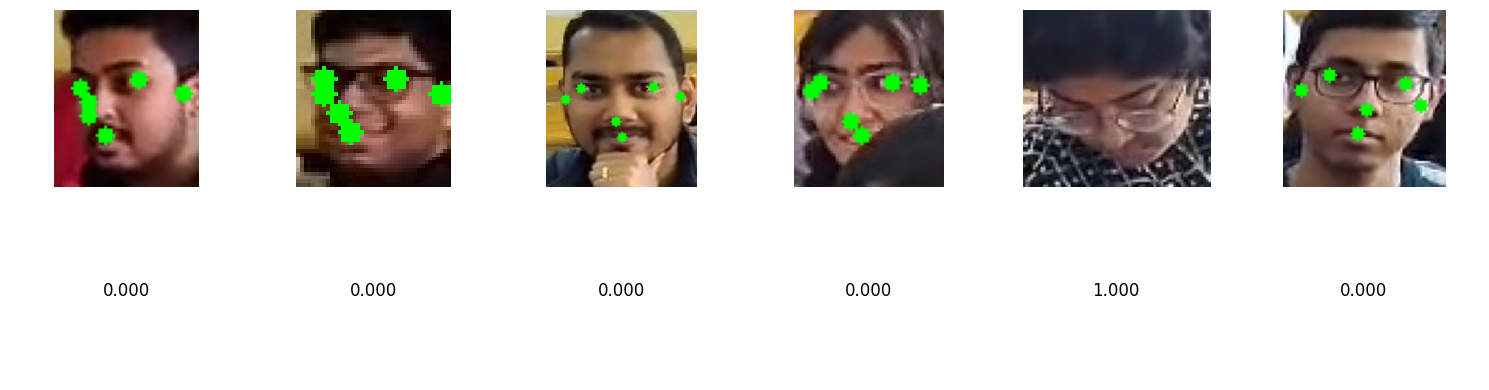

In [ ]:
import os
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------- CONFIG --------
face_dir = "/home/guest/cropped_faces" # Folder containing cropped faces
selected_faces = [
    "frame477_obj1.jpg", "frame477_obj2.jpg", "frame106_obj2.jpg",
    "frame212_obj4.jpg", "frame212_obj7.jpg", "frame53_obj1.jpg"
]
required_landmarks = {
    "right_eye": 33,
    "left_eye": 263,
    "nose_tip": 1,
    "mouth_center": 13,
    "right_ear": 234,
    "left_ear": 454
}

# -------- INIT --------
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

scores = []
face_images = []

for face_file in selected_faces:
    img_path = os.path.join(face_dir, face_file)
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = face_mesh.process(img_rgb)
    detected_count = 0

    if results.multi_face_landmarks:
        for idx in required_landmarks.values():
            if idx < len(results.multi_face_landmarks[0].landmark):
                x, y = results.multi_face_landmarks[0].landmark[idx].x, results.multi_face_landmarks[0].landmark[idx].y
                if not (np.isnan(x) or np.isnan(y)):
                    detected_count += 1

        # Draw landmarks
        for idx in required_landmarks.values():
            h, w, _ = img.shape
            x = int(results.multi_face_landmarks[0].landmark[idx].x * w)
            y = int(results.multi_face_landmarks[0].landmark[idx].y * h)
            cv2.circle(img, (x, y), 3, (0, 255, 0), -1)
    else:
        detected_count = 0

    occlusion_score = 1 - (detected_count / len(required_landmarks))
    scores.append((face_file, round(occlusion_score, 3)))
    face_images.append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# -------- SAVE RESULTS --------
df = pd.DataFrame(scores, columns=["Face ID", "Occlusion Score"])
print(df)

# -------- PLOT --------
fig, axs = plt.subplots(2, len(face_images), figsize=(15, 4))
for i, (img, (_, score)) in enumerate(zip(face_images, scores)):
    axs[0, i].imshow(img)
    axs[0, i].axis("off")
    axs[1, i].text(0.5, 0.5, f"{score:.3f}", fontsize=12, ha='center', va='center')
    axs[1, i].axis("off")

axs[0, 0].set_ylabel("Extracted Faces")
axs[1, 0].set_ylabel("Occlusion Score")
plt.tight_layout()
plt.show()


In [ ]:
import cv2
import mediapipe as mp
import os

# Paths
face_dir = "/home/guest/cropped_faces"
selected_faces = [
    "frame477_obj1.jpg", "frame106_obj2.jpg", "frame212_obj4.jpg",
    "frame212_obj7.jpg", "frame53_obj1.jpg"
]

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

for face_file in selected_faces:
    img_path = os.path.join(face_dir, face_file)

    if not os.path.exists(img_path):
        print(f"[ERROR] File not found: {img_path}")
        continue

    img = cv2.imread(img_path)
    if img is None:
        print(f"[ERROR] Could not load image: {img_path}")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        print(f"[INFO] No face landmarks detected for {face_file}")
        continue

    # Count visible key landmarks
    detected_count = 0
    for face_landmarks in results.multi_face_landmarks:
        for landmark in face_landmarks.landmark:
            if landmark.visibility > 0.5:  # Adjust threshold if needed
                detected_count += 1

    occlusion_score = 1 - (detected_count / len(results.multi_face_landmarks[0].landmark))
    print(f"{face_file} → Occlusion Score: {occlusion_score:.3f}")


frame477_obj1.jpg → Occlusion Score: 1.000
frame106_obj2.jpg → Occlusion Score: 1.000
frame212_obj4.jpg → Occlusion Score: 1.000
[INFO] No face landmarks detected for frame212_obj7.jpg
frame53_obj1.jpg → Occlusion Score: 1.000


I0000 00:00:1755201926.067365 1513433 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1755201926.102006 1514726 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.247.01), renderer: NVIDIA A16/PCIe/SSE2
W0000 00:00:1755201926.106149 1514686 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1755201926.123428 1514685 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


# Occlusion Score

In [ ]:
import cv2
import mediapipe as mp
import os
import numpy as np

# MediaPipe Face Mesh setup
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)

# Paths
input_folder = "/home/guest/Mahesh_MTP/data/07_11_2025/faces"

def compute_occlusion_score(image_path):
    image = cv2.imread(image_path)
    if image is None:
        return None

    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(rgb_image)

    if not results.multi_face_landmarks:
        return 0.0  # No face detected → fully occluded or missing

    landmarks = results.multi_face_landmarks[0].landmark

    # We'll consider all 468 landmarks
    visible_count = 0
    total_count = len(landmarks)

    h, w, _ = image.shape

    for lm in landmarks:
        x_px, y_px = int(lm.x * w), int(lm.y * h)

        # Check if the landmark is inside image bounds
        if 0 <= x_px < w and 0 <= y_px < h:
            # We can check brightness to guess occlusion:
            if np.mean(image[y_px, x_px]) > 20:  # pixel not too dark
                visible_count += 1

    # Fraction of visible landmarks
    return round(visible_count / total_count, 3)

# Loop through all images
for filename in os.listdir(input_folder):
    if filename.lower().endswith(".jpg"):
        img_path = os.path.join(input_folder, filename)
        score = compute_occlusion_score(img_path)
        print(f"{filename}: Occlusion Score = {score}")


I0000 00:00:1763890055.561751   40885 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1763890055.594990   41284 gl_context.cc:369] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.274.02), renderer: NVIDIA A16/PCIe/SSE2
W0000 00:00:1763890055.599144   41237 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1763890055.616835   41235 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


AttributeError: module 'google.protobuf.message_factory' has no attribute 'GetMessageClass'

In [ ]:
import json
import os

# pick one of your json files
json_path = "/home/guest/Mahesh_MTP/temp/embeddings/IMG_1342/embeddings_dict.json"

with open(json_path, "r") as f:
    embeddings_dict = json.load(f)

# print total number of entries
print("Total entries:", len(embeddings_dict))

# print 3 sample keys
sample_keys = list(embeddings_dict.keys())[:3]
print("Sample keys:", sample_keys)

# check one embedding
first_key = sample_keys[0]
embedding = embeddings_dict[first_key]
print("Embedding length:", len(embedding))
print("First 5 values of embedding:", embedding[:5])


Total entries: 941
Sample keys: ['frame476face1.jpg', 'frame510face1.jpg', 'frame426face1.jpg']
Embedding length: 4096
First 5 values of embedding: [0.0, 0.0, 0.0, 0.0, 0.0]


## Centroid

In [ ]:
#!/usr/bin/env python3
import os
import json
import numpy as np
from PIL import Image
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# ───────────── CONFIG ─────────────
CLUSTER_ROOT = "/home/guest/Mahesh_MTP/clusterfiles"
EMBEDDINGS_ROOT = "/home/guest/Mahesh_MTP/temp/embeddings"
OUTPUT_XLSX = "/home/guest/Mahesh_MTP/attendancefiles/person_faces_wo_padding_centroid.xlsx"
REFERENCE_FILE = "/home/guest/Mahesh_MTP/attendancefiles/person_reference1.pkl"
TEST_VIDEOS = [
    "IMG_1489_DBSCAN_correlation_0.28_11",
    "IMG_1407_DBSCAN_correlation_0.28_11",
    "IMG_1447_DBSCAN_correlation_0.28_11",
    "IMG_1349_DBSCAN_correlation_0.28_11",
    "IMG_1357_DBSCAN_correlation_0.28_11",
    "IMG_1371_DBSCAN_correlation_0.28_11",
    "IMG_1487_DBSCAN_correlation_0.28_11",
    "IMG_1340_DBSCAN_correlation_0.28_11",
    #"IMG_1342_DBSCAN_correlation_0.28_11",
    "IMG_1444_DBSCAN_correlation_0.28_11",
    "IMG_1491_DBSCAN_correlation_0.28_11",
    "IMG_1372_DBSCAN_correlation_0.28_11",
    "IMG_1373_DBSCAN_correlation_0.28_11",
    "IMG_1350_DBSCAN_correlation_0.28_11",
    "IMG_1362_DBSCAN_correlation_0.28_11"

    #"IMG_1453_DBSCAN_correlation_0.28_11",



]
THUMB_SIZE = (100, 100)  # width, height
SIM_THRESHOLD = 0.75      # cosine similarity threshold to match person across videos

# ───────────── FUNCTIONS ─────────────
def get_video_name(folder_name):
    return folder_name.split('_DBSCAN')[0]

def load_embeddings(video_name):
    emb_path = os.path.join(EMBEDDINGS_ROOT, video_name, "embeddings_dict.json")
    with open(emb_path, 'r') as f:
        emb_dict = json.load(f)
    return emb_dict

def best_face_in_cluster(cluster_dir, embeddings_dict):
    face_files = [f for f in os.listdir(cluster_dir) if f.lower().endswith('.jpg')]
    if not face_files:
        return None, None

    embs = []
    for face_file in face_files:
        key = face_file
        if key in embeddings_dict:
            embs.append(np.array(embeddings_dict[key]))
        else:
            embs.append(np.zeros(4096))
    embs = np.array(embs)

    centroid = np.mean(embs, axis=0)
    distances = np.linalg.norm(embs - centroid, axis=1)
    best_idx = np.argmin(distances)
    return os.path.join(cluster_dir, face_files[best_idx]), embs

def match_person(centroid, persons_data):
    """Return person index if matched, else None"""
    if not persons_data:
        return None, 0
    sims = [cosine_similarity([centroid], [p['centroid']])[0][0] for p in persons_data]
    max_sim = max(sims)
    if max_sim > SIM_THRESHOLD:
        idx = sims.index(max_sim)
        return idx, max_sim
    return None, max_sim

# ───────────── LOAD EXISTING REFERENCE ─────────────
if os.path.exists(REFERENCE_FILE):
    with open(REFERENCE_FILE, 'rb') as f:
        persons_data = pickle.load(f)
    person_counter = max([p['person_id'] for p in persons_data]) + 1
else:
    persons_data = []
    person_counter = 1

# ───────────── PROCESS VIDEOS ─────────────
for video_folder in TEST_VIDEOS:
    video_name = get_video_name(video_folder)
    print(f"[INFO] Processing video '{video_folder}' -> video_name = '{video_name}'")
    embeddings_dict = load_embeddings(video_name)

    cluster_dirs = [os.path.join(CLUSTER_ROOT, video_folder, d)
                    for d in os.listdir(os.path.join(CLUSTER_ROOT, video_folder))
                    if os.path.isdir(os.path.join(CLUSTER_ROOT, video_folder, d))]
    print(f"[INFO] Found {len(cluster_dirs)} clusters")

    for cdir in cluster_dirs:
        best_face, embs = best_face_in_cluster(cdir, embeddings_dict)
        if best_face is None:
            continue

        centroid = np.mean(embs, axis=0)
        match_idx, sim = match_person(centroid, persons_data)

        if match_idx is not None:
            person = persons_data[match_idx]
            person['faces'][video_name] = [best_face]
            # update centroid as running mean of all embeddings
            all_embs = [person['centroid']] + [centroid]
            person['centroid'] = np.mean(all_embs, axis=0)
            print(f"[MATCH] cluster {cdir} -> existing Person_{person['person_id']} (sim={sim:.3f})")
        else:
            person_data = {
                'person_id': person_counter,
                'faces': {video_name: [best_face]},
                'centroid': centroid
            }
            persons_data.append(person_data)
            print(f"[NEW] cluster {cdir} -> Person_{person_counter}")
            person_counter += 1

# ───────────── SAVE REFERENCE ─────────────
with open(REFERENCE_FILE, 'wb') as f:
    pickle.dump(persons_data, f)
# ───────────── WRITE EXCEL ─────────────
wb = Workbook()
ws = wb.active
ws.title = "Faces"

# Header row
ws.cell(row=1, column=1, value="Person_ID")
for col, video_folder in enumerate(TEST_VIDEOS, start=2):
    ws.cell(row=1, column=col, value=get_video_name(video_folder))

# Fill rows with faces
for row, person in enumerate(persons_data, start=2):
    ws.cell(row=row, column=1, value=f"Person_{person['person_id']}")
    for col, video_folder in enumerate(TEST_VIDEOS, start=2):
        video_name = get_video_name(video_folder)
        img_path_list = person['faces'].get(video_name, [])
        if img_path_list:
            img_path = img_path_list[0]

            # ✅ Skip if file missing
            if not os.path.exists(img_path):
                print(f"[WARNING] Missing image: {img_path}, skipping...")
                continue

            pil_img = Image.open(img_path).resize(THUMB_SIZE)
            img_bytes = BytesIO()
            pil_img.save(img_bytes, format='PNG')
            img_bytes.seek(0)
            xl_img = XLImage(img_bytes)
            cell_ref = ws.cell(row=row, column=col).coordinate
            ws.add_image(xl_img, cell_ref)
            ws.row_dimensions[row].height = 80
            ws.column_dimensions[ws.cell(row=1, column=col).column_letter].width = 18

wb.save(OUTPUT_XLSX)
print(f"[DONE] Excel saved at {OUTPUT_XLSX}")




[INFO] Processing video 'IMG_1489_DBSCAN_correlation_0.28_11' -> video_name = 'IMG_1489'
[INFO] Found 28 clusters
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/15 -> existing Person_192 (sim=1.000)
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/16 -> existing Person_8 (sim=0.955)
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/19 -> existing Person_2 (sim=0.952)
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/8 -> existing Person_26 (sim=0.916)
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/10 -> existing Person_55 (sim=0.972)
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/7 -> existing Person_93 (sim=0.908)
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/3 -> existing Person_42 (sim=0.954)
[MATCH] cluster

In [ ]:
# ───────────── WRITE EXCEL ─────────────
wb = Workbook()
ws = wb.active
ws.title = "Faces"

# Header row
ws.cell(row=1, column=1, value="Person_ID")
for col, video_folder in enumerate(TEST_VIDEOS, start=2):
    ws.cell(row=1, column=col, value=get_video_name(video_folder))

# Fill rows
for row, person in enumerate(persons_data, start=2):
    ws.cell(row=row, column=1, value=f"Person_{person['person_id']}")
    for col, video_folder in enumerate(TEST_VIDEOS, start=2):
        video_name = get_video_name(video_folder)
        img_path_list = person['faces'].get(video_name, [])
        if img_path_list:
            img_path = img_path_list[0]
            pil_img = Image.open(img_path).resize(THUMB_SIZE)
            img_bytes = BytesIO()
            pil_img.save(img_bytes, format='PNG')
            img_bytes.seek(0)
            xl_img = XLImage(img_bytes)
            cell_ref = ws.cell(row=row, column=col).coordinate
            ws.add_image(xl_img, cell_ref)
            ws.row_dimensions[row].height = 80
            ws.column_dimensions[ws.cell(row=1, column=col).column_letter].width = 18

wb.save(OUTPUT_XLSX)
print(f"[DONE] Excel saved at {OUTPUT_XLSX}")
print(f"[DONE] Reference saved at {REFERENCE_FILE}")


In [ ]:
#!/usr/bin/env python3
import os
import json
import numpy as np
from PIL import Image
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from io import BytesIO
import pickle
import cv2   # ✅ for sharpness check
from scipy.spatial.distance import correlation  # ✅ replaced cosine with correlation

# ───────────── CONFIG ─────────────
CLUSTER_ROOT = "/home/guest/Mahesh_MTP/clusterfiles"
EMBEDDINGS_ROOT = "/home/guest/Mahesh_MTP/temp/embeddings"
OUTPUT_XLSX = "/home/guest/Mahesh_MTP/attendancefiles/person_faces_corr.xlsx"
REFERENCE_FILE = "/home/guest/Mahesh_MTP/attendancefiles/person_reference_corr.pkl"
TEST_VIDEOS = [
    "IMG_1489_DBSCAN_correlation_0.28_11",
    "IMG_1407_DBSCAN_correlation_0.28_11",
    "IMG_1447_DBSCAN_correlation_0.28_11",
    "IMG_1349_DBSCAN_correlation_0.28_11",
    "IMG_1357_DBSCAN_correlation_0.28_11",
    "IMG_1371_DBSCAN_correlation_0.28_11",
    "IMG_1487_DBSCAN_correlation_0.28_11",
    "IMG_1340_DBSCAN_correlation_0.28_11",
    #"IMG_1342_DBSCAN_correlation_0.28_11",
    "IMG_1444_DBSCAN_correlation_0.28_11",
    "IMG_1491_DBSCAN_correlation_0.28_11",
    "IMG_1372_DBSCAN_correlation_0.28_11",
    "IMG_1373_DBSCAN_correlation_0.28_11",
    "IMG_1350_DBSCAN_correlation_0.28_11",
    "IMG_1362_DBSCAN_correlation_0.28_11"
]
THUMB_SIZE = (100, 100)  # width, height
SIM_THRESHOLD = 0.75      # correlation similarity threshold

# ───────────── FUNCTIONS ─────────────
def get_video_name(folder_name):
    return folder_name.split('_DBSCAN')[0]

def load_embeddings(video_name):
    emb_path = os.path.join(EMBEDDINGS_ROOT, video_name, "embeddings_dict.json")
    with open(emb_path, 'r') as f:
        emb_dict = json.load(f)
    return emb_dict

def image_sharpness(img_path):
    """Return sharpness score using Laplacian variance."""
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return 0
    return cv2.Laplacian(img, cv2.CV_64F).var()

def best_face_in_cluster(cluster_dir, embeddings_dict):
    face_files = [f for f in os.listdir(cluster_dir) if f.lower().endswith('.jpg')]
    if not face_files:
        return None, None

    embs = []
    paths = []
    for face_file in face_files:
        key = face_file
        if key in embeddings_dict:
            embs.append(np.array(embeddings_dict[key]))
        else:
            embs.append(np.zeros(4096))
        paths.append(os.path.join(cluster_dir, face_file))

    embs = np.array(embs)
    centroid = np.mean(embs, axis=0)

    # Distance to centroid
    distances = np.linalg.norm(embs - centroid, axis=1)

    # Sharpness scores
    sharpness_scores = [image_sharpness(p) for p in paths]

    # Normalize both criteria
    if np.max(distances) > 0:
        dist_norm = 1 - (distances / np.max(distances))  # higher = closer to centroid
    else:
        dist_norm = np.ones_like(distances)

    if np.max(sharpness_scores) > 0:
        sharp_norm = sharpness_scores / np.max(sharpness_scores)
    else:
        sharp_norm = np.zeros_like(sharpness_scores)

    # Combined score
    combined_score = 0.5 * dist_norm + 0.5 * sharp_norm
    best_idx = np.argmax(combined_score)

    return paths[best_idx], embs

def match_person(centroid, persons_data):
    if not persons_data:
        return None, 0
    sims = [1 - correlation(centroid, p['centroid']) for p in persons_data]  # ✅ correlation similarity
    max_sim = max(sims)
    if max_sim > SIM_THRESHOLD:
        idx = sims.index(max_sim)
        return idx, max_sim
    return None, max_sim

# ───────────── LOAD EXISTING REFERENCE ─────────────
if os.path.exists(REFERENCE_FILE):
    with open(REFERENCE_FILE, 'rb') as f:
        persons_data = pickle.load(f)
    person_counter = max([p['person_id'] for p in persons_data]) + 1
else:
    persons_data = []
    person_counter = 1

# ───────────── PROCESS VIDEOS ─────────────
for video_folder in TEST_VIDEOS:
    video_name = get_video_name(video_folder)
    print(f"[INFO] Processing video '{video_folder}' -> video_name = '{video_name}'")
    embeddings_dict = load_embeddings(video_name)

    cluster_dirs = [os.path.join(CLUSTER_ROOT, video_folder, d)
                    for d in os.listdir(os.path.join(CLUSTER_ROOT, video_folder))
                    if os.path.isdir(os.path.join(CLUSTER_ROOT, video_folder, d))]
    print(f"[INFO] Found {len(cluster_dirs)} clusters")

    for cdir in cluster_dirs:
        best_face, embs = best_face_in_cluster(cdir, embeddings_dict)
        if best_face is None:
            continue

        centroid = np.mean(embs, axis=0)
        match_idx, sim = match_person(centroid, persons_data)

        if match_idx is not None:
            person = persons_data[match_idx]
            person['faces'][video_name] = [best_face]
            # update centroid as running mean
            all_embs = [person['centroid'], centroid]
            person['centroid'] = np.mean(all_embs, axis=0)
            print(f"[MATCH] cluster {cdir} -> existing Person_{person['person_id']} (corr_sim={sim:.3f})")
        else:
            person_data = {
                'person_id': person_counter,
                'faces': {video_name: [best_face]},
                'centroid': centroid
            }
            persons_data.append(person_data)
            print(f"[NEW] cluster {cdir} -> Person_{person_counter}")
            person_counter += 1

# ───────────── SAVE REFERENCE ─────────────
with open(REFERENCE_FILE, 'wb') as f:
    pickle.dump(persons_data, f)

# ───────────── WRITE EXCEL ─────────────
wb = Workbook()
ws = wb.active
ws.title = "Faces"

# Header row
ws.cell(row=1, column=1, value="Person_ID")
for col, video_folder in enumerate(TEST_VIDEOS, start=2):
    ws.cell(row=1, column=col, value=get_video_name(video_folder))

# Fill rows with faces
for row, person in enumerate(persons_data, start=2):
    ws.cell(row=row, column=1, value=f"Person_{person['person_id']}")
    for col, video_folder in enumerate(TEST_VIDEOS, start=2):
        video_name = get_video_name(video_folder)
        img_path_list = person['faces'].get(video_name, [])
        if img_path_list:
            img_path = img_path_list[0]

            if not os.path.exists(img_path):
                print(f"[WARNING] Missing image: {img_path}, skipping...")
                continue

            pil_img = Image.open(img_path).resize(THUMB_SIZE)
            img_bytes = BytesIO()
            pil_img.save(img_bytes, format='PNG')
            img_bytes.seek(0)
            xl_img = XLImage(img_bytes)
            cell_ref = ws.cell(row=row, column=col).coordinate
            ws.add_image(xl_img, cell_ref)
            ws.row_dimensions[row].height = 80
            ws.column_dimensions[ws.cell(row=1, column=col).column_letter].width = 18

wb.save(OUTPUT_XLSX)
print(f"[DONE] Excel saved at {OUTPUT_XLSX}")


[INFO] Processing video 'IMG_1489_DBSCAN_correlation_0.28_11' -> video_name = 'IMG_1489'
[INFO] Found 28 clusters
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/15 -> Person_1
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/16 -> Person_2
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/19 -> Person_3
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/8 -> Person_4
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/10 -> Person_5
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/7 -> Person_6
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/3 -> Person_7
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28_11/6 -> Person_8
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1489_DBSCAN_correlation_0.28

## other

In [ ]:
#!/usr/bin/env python3
import os
import json
import numpy as np
from PIL import Image
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage
from io import BytesIO
from sklearn.metrics.pairwise import cosine_similarity
import pickle

# ───────────── CONFIG ─────────────
CLUSTER_ROOT = "/home/guest/Mahesh_MTP/clusterfiles"
EMBEDDINGS_ROOT = "/home/guest/Mahesh_MTP/temp/embeddings"
OUTPUT_XLSX = "/home/guest/Mahesh_MTP/attendancefiles/person_faces2_other.xlsx"
REFERENCE_FILE = "/home/guest/Mahesh_MTP/attendancefiles/person_reference2.pkl"
TEST_VIDEOS = [
    "IMG_1340_DBSCAN_correlation_0.28_11",
    #"IMG_1342_DBSCAN_correlation_0.28_11",
    "IMG_1349_DBSCAN_correlation_0.28_11",
    "IMG_1350_DBSCAN_correlation_0.28_11",
    "IMG_1357_DBSCAN_correlation_0.28_11",
    "IMG_1362_DBSCAN_correlation_0.28_11",
    "IMG_1371_DBSCAN_correlation_0.28_11",
    "IMG_1372_DBSCAN_correlation_0.28_11",
    "IMG_1373_DBSCAN_correlation_0.28_11",
    "IMG_1407_DBSCAN_correlation_0.28_11",
    "IMG_1444_DBSCAN_correlation_0.28_11",
    "IMG_1447_DBSCAN_correlation_0.28_11",
    "IMG_1453_DBSCAN_correlation_0.28_11",
    "IMG_1487_DBSCAN_correlation_0.28_11",
    "IMG_1489_DBSCAN_correlation_0.28_11",
    "IMG_1491_DBSCAN_correlation_0.28_11"
]
THUMB_SIZE = (100, 100)
SIM_THRESHOLD = 0.75

# ───────────── FUNCTIONS ─────────────
def get_video_name(folder_name):
    return folder_name.split('_DBSCAN')[0]

def load_embeddings(video_name):
    emb_path = os.path.join(EMBEDDINGS_ROOT, video_name, "embeddings_dict.json")
    with open(emb_path, 'r') as f:
        emb_dict = json.load(f)
    return emb_dict

def best_face_in_cluster(cluster_dir, embeddings_dict):
    face_files = [f for f in os.listdir(cluster_dir) if f.lower().endswith('.jpg')]
    if not face_files:
        return None, None, None
    embs = []
    for face_file in face_files:
        key = face_file
        if key in embeddings_dict:
            embs.append(np.array(embeddings_dict[key]))
        else:
            embs.append(np.zeros(4096))
    embs = np.array(embs)
    centroid = np.mean(embs, axis=0)
    distances = np.linalg.norm(embs - centroid, axis=1)
    best_idx = np.argmin(distances)
    return os.path.join(cluster_dir, face_files[best_idx]), centroid, embs

# ───────────── LOAD OR INIT PERSON DATA ─────────────
if os.path.exists(REFERENCE_FILE):
    with open(REFERENCE_FILE, 'rb') as f:
        persons_data = pickle.load(f)
    person_counter = max([p['person_id'] for p in persons_data]) + 1
else:
    persons_data = []
    person_counter = 1

# ───────────── PROCESS VIDEOS ─────────────
for video_folder in TEST_VIDEOS:
    video_name = get_video_name(video_folder)
    print(f"[INFO] Processing cluster folder '{video_folder}' -> video_name = '{video_name}'")
    embeddings_dict = load_embeddings(video_name)

    cluster_dirs = [os.path.join(CLUSTER_ROOT, video_folder, d) for d in os.listdir(os.path.join(CLUSTER_ROOT, video_folder))
                    if os.path.isdir(os.path.join(CLUSTER_ROOT, video_folder, d))]
    print(f"[INFO] Found {len(cluster_dirs)} cluster dirs in {video_folder}")

    for cdir in cluster_dirs:
        best_face, centroid, cluster_embs = best_face_in_cluster(cdir, embeddings_dict)
        if best_face is None:
            continue

        # Try to match with existing persons
        matched = False
        for person in persons_data:
            # Compare new cluster embeddings with all embeddings of this person
            sim_matrix = cosine_similarity(cluster_embs, person['embeddings'])
            max_sim = np.max(sim_matrix)
            if max_sim >= SIM_THRESHOLD:
                # Match found
                person['faces'][video_name] = [best_face]
                person['embeddings'] = np.vstack([person['embeddings'], cluster_embs])
                matched = True
                print(f"[MATCH] cluster {cdir} -> existing Person_{person['person_id']} (sim={max_sim:.3f})")
                break

        if not matched:
            # New person
            person_data = {
                'person_id': person_counter,
                'faces': {video_name: [best_face]},
                'embeddings': cluster_embs
            }
            persons_data.append(person_data)
            print(f"[NEW] cluster {cdir} -> Person_{person_counter}")
            person_counter += 1

# ───────────── SAVE PERSON REFERENCE ─────────────
with open(REFERENCE_FILE, 'wb') as f:
    pickle.dump(persons_data, f)

# ───────────── WRITE EXCEL ─────────────
wb = Workbook()
ws = wb.active
ws.title = "Faces"

# Header row
ws.cell(row=1, column=1, value="Person_ID")
for col, video_folder in enumerate(TEST_VIDEOS, start=2):
    ws.cell(row=1, column=col, value=get_video_name(video_folder))

# Fill rows with faces
for row, person in enumerate(persons_data, start=2):
    ws.cell(row=row, column=1, value=f"Person_{person['person_id']}")
    for col, video_folder in enumerate(TEST_VIDEOS, start=2):
        video_name = get_video_name(video_folder)
        img_path_list = person['faces'].get(video_name, [])
        if img_path_list:
            img_path = img_path_list[0]

            # ✅ Skip if file missing
            if not os.path.exists(img_path):
                print(f"[WARNING] Missing image: {img_path}, skipping...")
                continue

            pil_img = Image.open(img_path).resize(THUMB_SIZE)
            img_bytes = BytesIO()
            pil_img.save(img_bytes, format='PNG')
            img_bytes.seek(0)
            xl_img = XLImage(img_bytes)
            cell_ref = ws.cell(row=row, column=col).coordinate
            ws.add_image(xl_img, cell_ref)
            ws.row_dimensions[row].height = 80
            ws.column_dimensions[ws.cell(row=1, column=col).column_letter].width = 18

wb.save(OUTPUT_XLSX)
print(f"[DONE] Excel saved at {OUTPUT_XLSX}")



[INFO] Processing cluster folder 'IMG_1340_DBSCAN_correlation_0.28_11' -> video_name = 'IMG_1340'
[INFO] Found 19 cluster dirs in IMG_1340_DBSCAN_correlation_0.28_11
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation_0.28_11/15 -> Person_79
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation_0.28_11/16 -> Person_80
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation_0.28_11/8 -> existing Person_60 (sim=0.776)
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation_0.28_11/10 -> existing Person_4 (sim=0.818)
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation_0.28_11/7 -> Person_81
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation_0.28_11/3 -> Person_82
[NEW] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation_0.28_11/6 -> Person_83
[MATCH] cluster /home/guest/Mahesh_MTP/clusterfiles/IMG_1340_DBSCAN_correlation

In [ ]:
# ───────────── WRITE EXCEL ─────────────
wb = Workbook()
ws = wb.active
ws.title = "Faces"

# Header row
ws.cell(row=1, column=1, value="Person_ID")
for col, video_folder in enumerate(TEST_VIDEOS, start=2):
    ws.cell(row=1, column=col, value=get_video_name(video_folder))

# Fill rows with faces
for row, person in enumerate(persons_data, start=2):
    ws.cell(row=row, column=1, value=f"Person_{person['person_id']}")
    for col, video_folder in enumerate(TEST_VIDEOS, start=2):
        video_name = get_video_name(video_folder)
        img_path_list = person['faces'].get(video_name, [])
        if img_path_list:
            img_path = img_path_list[0]
            pil_img = Image.open(img_path).resize(THUMB_SIZE)
            img_bytes = BytesIO()
            pil_img.save(img_bytes, format='PNG')
            img_bytes.seek(0)
            xl_img = XLImage(img_bytes)
            cell_ref = ws.cell(row=row, column=col).coordinate
            ws.add_image(xl_img, cell_ref)
            ws.row_dimensions[row].height = 80
            ws.column_dimensions[ws.cell(row=1, column=col).column_letter].width = 18

wb.save(OUTPUT_XLSX)
print(f"[DONE] Excel saved at {OUTPUT_XLSX}")
